# BAYESIAN OPTIMISATION??
# GAUSSIAN

https://arxiv.org/pdf/1206.2944.pdf

# Import

In [1]:
import warnings
warnings.filterwarnings(action='once')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC #???????????????//
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, kendalltau

from astropy.table import QTable, join
import astropy.coordinates as coord
import astropy.units as u
from time import time

font = {'family': 'Georgia'}
plt.rc('font',**font)

## Load required data

In [3]:
with open('./pickle/bounds.pk','rb') as f:
    bounds = pickle.load(f)
master_cat = pd.read_csv('./catdata/master_catalog_jan_2023.csv')
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [4]:
object_match_files = ['matches_delta006.pk','matches_delta005.pk','matches_delta004.pk']

In [5]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'

train_file = 'training_data_2702_j.pk'
train_file = 'training_data_0203_jhk.pk'

with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

In [6]:
def load_cat(field): # change to match-case
    bounds = [50,100,150,200,235,257,279,320,360,406]
    for b in range(len(bounds)):
        if field <= bounds[b]:
            to_load = cat_files[b]
            break
    with open(f'./pickle/{to_load}','rb') as f:
        catalogue = pickle.load(f)
    return catalogue[field]

In [7]:
load_cat.__name__

'load_cat'

## 19/02 Adding stars back in, and labelling stars and galaxies as 'non-gc'

In [6]:
for r in training_data[training_data['class']=='star'].index:
    training_data.loc[r,'class'] = 'non-gc'

In [7]:
for r in training_data[training_data['class']=='galaxy'].index:
    training_data.loc[r,'class'] = 'non-gc'

In [8]:
training_data

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g,j,h,k,ph_qual,2mass_acc
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001,13.028,12.881,12.805,AAA,False
1,C30,non-gc,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000,15.869,15.216,14.756,AAB,True
2,LAMOST-C22,non-gc,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000,15.251,14.503,13.918,AAA,True
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000,16.429,15.589,15.154,BBC,False
4,LAMOST-C18,non-gc,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001,14.838,14.277,13.847,AAA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106,-1.500999,11.881,11.436,11.314,AAA,False
1330,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156,-1.016001,13.321,12.966,12.889,AAA,False
1331,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163,-0.997000,14.687,14.317,14.254,AAA,False
1332,PA-N147-3,gc,19.910000,20.820999,0.004,0.004,8.542029,49.044243,402,101369,91,36,-0.910999,14.378,13.857,13.694,AAA,False


In [9]:
with open(f'./pickle/training_data/training_data_1902_with_stars.pk','wb') as f: #m[-4:-3] = the delta number
    pickle.dump(training_data,f)

# Training Data Generator

In [8]:
# 23.01.26 18:29
def generate_training_data(matches, crowding=300) -> pd.DataFrame:
    cat = load_cat(1)
    
    columns = ['obj_id','class','i','g','di','dg','ra','dec','field','pdidx','rbcidx','nearby']
    values = []
    object_ids = []
    
    #TEMP
    crowded_objects = []
    
    
    for field in matches: # iterate through each field ID
        working_field = matches[field] # take the list of matches e.g. working_field = [(166727, 2642), (159637, 2646)]
        if field not in cat: # load the correct catalogue
            cat = load_cat(field)
        for m in working_field: # iterate through each match (a tuple) and grab values from catalogues
            
            if m[2] > crowding: # testing
                crowded_objects.append(m[1:])
                continue
            
            obj_id = master_cat.loc[m[1]].ID
            class_ = master_cat.loc[m[1]].CLASS
            
            if obj_id in object_ids: continue # if we've already added the object then skip
            else: object_ids.append(obj_id)   # else add it to the list of ids
            
            if class_ == 1: class_str = 'gc' # convert class numbers into strings
            elif class_ == 4: class_str = 'galaxy'
            elif class_ == 6: class_str = 'star'
            else: continue # skip non-gc/gal/stars
            
            # collect required data
            row = cat[field][m[0]]
            ra = row['RA']
            dec = row['Dec']
            g = row['g']
            i = row['i']
            dg = row['dg']
            di = row['di']
            
            values.append([obj_id,class_str,i,g,di,dg,ra,dec,field,m[0],m[1],m[2]])
    
    training_data_dict = dict(zip(columns,zip(*values))) # zip values and columns together into a dict (columns as keys)
    training_data_df = pd.DataFrame(training_data_dict) # put into pd Dataframe
    return training_data_df, crowded_objects

In [8]:
#generate training data for a range of crowding, and delta, values
object_match_files = ['matches_delta006.pk','matches_delta005.pk','matches_delta004.pk','matches_delta003.pk']
#TEMP
object_match_files = ['matches_delta005_0502.pk']

for m in object_match_files:
    obj_mat = pickle.load(open(f'./pickle/matches/{m}','rb'))
    #training_data = {}
    for c in crowding_test_values[0:1]:
        print(c)
        training_data, _ = generate_training_data(obj_mat, crowding=c)
    with open(f'./pickle/training_data/training_data_0502.pk','wb') as f: #m[-4:-3] = the delta number
        #pickle.dump(training_data,f)

C:\Users\jwarn\AppData\Local\Temp\ipykernel_24432\3899603297.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/matches/matches_delta005_0502.pk'>
  obj_mat = pickle.load(open(f'./pickle/matches/{m}','rb'))


NameError: name 'crowding_test_values' is not defined

To filter the training data for different crowding values, we can simply iterate back through the list of matches and remove the entries that are outside the threshold, instead of having to re-generate the data every time.

# Random Forest Classifier
***Newer functions are defined in predictions.ipynb***

In [175]:
# generate the classifier and return (with optional returning of train and test values)
def ranfor(df,train_size=0.8,n_estimators=50,criterion='gini',features=['i','g','g-i'], max_depth=None, 
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, max_features=2 ,stats=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size) # X
    # train the regressor model
    ran_for_class = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                    criterion=criterion, max_leaf_nodes=max_leaf_nodes, max_features=max_features,
                                    min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_jobs=-1
                                   ).fit(X_train,y_train)
    
    
    #acc = ran_for_class.score(X_test,y_test)
    
    #true = y_test.to_numpy()
    if stats:
        train_pred = ran_for_class.predict(X_train)
        test_pred = ran_for_class.predict(X_test)
        return ran_for_class, test_pred, y_test, train_pred, y_train
    else: return ran_for_class

In [9]:
# returns predictions for a given field, allowing a crowding parameter to filter training values
def rf_pred(field:int,train:pd.DataFrame,crowding=300,n_estimators=50,max_depth=None,max_leaf_nodes=None,min_samples_leaf=1,features=['i','g','g-i'],scale=False):
    training_data_ = train[train['nearby'] <= crowding]
    cat = load_cat(field)
    
    # drop rows with high delta g/i values
    cat_d = cat[cat['dg']+cat['di'] < 0.05]
    # drop stars & saturated points
    cat_candidate = cat_d[(cat_d['ig'] == 1) & (cat_d['ii'] == 1)]
    # add in g-i feature
    cat_candidate['g-i'] = cat_candidate['g']-cat_candidate['i']
    
    X = cat_candidate[features]
    X = X.to_pandas()
    
    res = ranfor(training_data_,train_size=0.8,n_estimators=n_estimators,criterion='gini',
                     features=features, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                     min_samples_leaf=1).predict(X)
    
    cat_pred = cat_candidate[['RA','Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','field']]
    cat_pred['pred'] = res
    return cat_pred

# MLP Classifier

In [9]:
def mlp_class(df,train_size=0.8,hidden_layer_sizes=(2,),activation='tanh',alpha=0.0001,max_iter=500,
              features=['i','g','g-i'],solver='lbfgs', max_fun=15000, stats=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split and scale the data
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
    # train the regressor model
    mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                   activation=activation, alpha=alpha, max_iter=max_iter, max_fun=max_fun,
                                   learning_rate='constant', solver=solver
                                  ).fit(X_train,y_train)
    if stats:
        # return test results for statistic measurements
        train_pred = mlp_classifier.predict(X_train)
        test_pred = mlp_classifier.predict(X_test)
        return mlp_classifier, test_pred, y_test, train_pred, y_train
    else: return mlp_classifier

In [10]:
def mlp_pred(field:int,clf):
    cat = load_cat(field)
    # drop rows with high delta g/i values
    cat_d = cat[cat['dg']+cat['di'] < 0.05]
    # drop stars & saturated points
    cat_candidate = cat_d[(cat_d['ig'] == 1) & (cat_d['ii'] == 1)]
    # add in g-i feature
    cat_candidate['g-i'] = cat_candidate['g']-cat_candidate['i']
    
    X = cat_candidate['i','g','g-i']
    X = X.to_pandas()
    
    X_scaled = preprocessing.StandardScaler().fit(X).transform(X)
    res = clf.predict(X_scaled)
    
    cat_pred = cat_candidate[['RA','Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','field']]
    cat_pred['pred'] = res
    return cat_pred

# Hyperparameter Tuning

### Misc Functions

In [11]:
def stats_append(stats, train_test_values, n):
    for i in [0,2]:
        tn, fp, fn, tp = confusion_matrix(train_test_values[i],train_test_values[i+1],labels=['galaxy','gc']).ravel()
        stats[n]['rec'][i>>1].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        stats[n]['acc'][i>>1].append( (tp+tn)/(tn+fp+fn+tp) ) # fraction of correctly identified objects
        stats[n]['prec'][i>>1].append( tp/(tp+fp) ) # fraction of correctly identified GCs, out of what were thought to be GCs    
    return stats

In [12]:
def plot_stats(stats: dict, xlabel: str, logx: bool = False):
    keys_ = sorted(stats.keys())
    acc = [stats[k]['acc'] for k in keys_]
    prec = [stats[k]['prec'] for k in keys_]
    rec = [stats[k]['rec'] for k in keys_]
    plt.plot(keys_, [a[0] for a in acc], label='accuracy (test)', c='#4888e8')
    plt.plot(keys_, [a[1] for a in acc], label='accuracy (train)', c='#025ee8')
    plt.plot(keys_, [p[0] for p in prec], label='precision (test)', c='#c94ef2')
    plt.plot(keys_, [p[1] for p in prec], label='precision (train)', c='#9902cc')
    plt.plot(keys_, [r[0] for r in rec], label='recall (test)', c='#fa6e64')
    plt.plot(keys_, [r[1] for r in rec], label='recall (train)', c='#d90e00')
    plt.xlabel(xlabel)
    plt.ylabel('score')
    if logx: plt.xscale('log')
    plt.legend()
    plt.show()

## MLP Hyperparameter Tuning

### Save/Load Recall Files

In [195]:
pickle.dump([sol_recall,alph_recall,ac_recall], open('./pickle/temp/recalls2704.pk','wb'))

C:\Users\jwarn\AppData\Local\Temp\ipykernel_3892\2569139554.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='./pickle/temp/recalls2604.pk'>
  pickle.dump([sol_recall,alph_recall,ac_recall], open('./pickle/temp/recalls2604.pk','wb'))


In [43]:
with open('./pickle/temp/recalls2604.pk','rb') as f:
    sol_recall,alph_recall,ac_recall = pickle.load(f)

### MLP Parameter Varying Functions

In [13]:
def mlp_vary_alpha(alpha_range: range, iterations: int, solver='lbfgs', verb=True) -> dict:
    stats = {}
    for n in alpha_range:
        if verb: print(f'calculating for alpha={n} ...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = mlp_class(training_data,alpha=n,stats=True,
                                          max_iter=1000, solver=solver)[1:]
            stats = stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

In [14]:
def mlp_vary_solver(solvers: list, iterations:int, alpha=1, verb=True):
    stats = {}
    for n in solvers:
        if verb: print(f'calculating for solver={n} ...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = mlp_class(training_data,solver=n,stats=True,
                                          max_iter=1000, alpha=alpha)[1:]
            stats = stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

### Alpha

In [259]:
## reset recall dictionary
alph_recall = {}
alph_accuracy = {}

In [260]:
# gather performance stats for mlp model
alphas = [0.01,0.03,0.05,0.07,0.085,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.55,0.6,0.7,0.8,0.9,1,1.05,1.1,1.15,1.2,1.25,1.5,2,2.5,3,4,5,7,10,12]
#alphas = np.arange(0.95,1.2,0.01)
alphas = [0.07,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.3,1.6,2,2.5,3,3.5,4,4.5,5,6,7,8,9,10,12]
alphas = [0.005,0.01,0.015,0.02,0.03,0.05,0.06,0.08,0.1,0.15,0.2,0.3,0.6,0.8,1,1.5,2,3,4,5,6,7,9,10]
#alphas = [0.01,0.02,0.05,0.1,0.2,0.5,0.8,1,1.5,2,3]
#alphas = [0.2,0.5,0.8,1,1.5,2,5,6,7,8,9,10,12,15]
#alphas = [0.001,0.005,0.008,0.01,0.05,0.08,0.1,0.5,1,2,3,4,5,6,7,8,9,10,10.3,10.6,10.8,11,12,13,14,20]
alphas=[0.0001,0.0003,0.0007,0.001,0.002,0.005,0.008,0.01,0.02,0.04,0.08,0.1,0.2,0.4,0.5,0.8,1,2,3,5]
alphas=[0.8,0.85,0.9,0.925,0.95,0.962,0.975,0.987,1,1.02,1.04,1.06,1.08,1.12,1.16]
hls = [(2,),(3,),(4,),(2,2),(2,3),(3,2),(5,)]
hln=0


for a in alphas:
    print(a)
    if a in alph_recall: continue
    alph_recall[a] = []
    alph_accuracy[a] = []
    for i in range(250):
        _, test_pred, test_true, _, _ = mlp_class(training_data,solver='lbfgs',stats=True,hidden_layer_sizes=hls[hln],
                                          max_iter=5000, alpha=a, activation='tanh',features=['g','i','g-i'])
    
        tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
        alph_recall[a].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        alph_accuracy[a].append( (tp+tn)/(tn+fp+fn+tp) )# fraction of correctly identified objects

0.8
0.85
0.9
0.925
0.95
0.962
0.975
0.987
1
1.02
1.04
1.06
1.08
1.12
1.16


Text(0.5, 1.0, 'Tuning of Alpha Parameter')

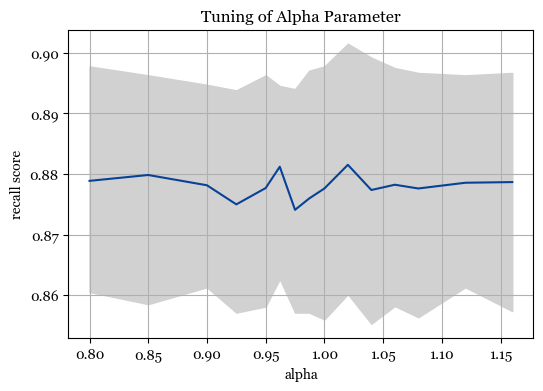

In [261]:
#### PLOT ####
plt.figure(dpi=100, figsize=(6,4))
alph_recall_keys = sorted(alph_recall.keys())
recall_low, recall_high  = np.quantile([alph_recall[i] for i in alph_recall_keys],[0.25,0.75], axis=1)
acc_low, acc_high  = np.quantile([alph_accuracy[i] for i in alph_accuracy],[0.25,0.75], axis=1)

plt.plot(alph_recall_keys, np.quantile([alph_recall[i] for i in alph_recall_keys],0.5, axis=1), c='#074297', label='recall')
plt.fill_between(alph_recall_keys,recall_low,recall_high,color='0.82')
#plt.plot(alph_accuracy.keys(), np.quantile([alph_accuracy[i] for i in alph_accuracy],0.5, axis=1), c='#970707', label='accuracy')
#plt.fill_between(recall.keys(),acc_low,acc_high,color='0.85')

plt.xlabel('alpha')
plt.ylabel('recall score')
#plt.legend()
plt.grid()
#plt.xscale('log')
#plt.xlim([6,20])
plt.title('Tuning of Alpha Parameter')
#plt.axvline(x=0.035, linewidth=1, linestyle='dashed', c='r', alpha=0.4)

#### Hello
$\alpha\beta\gamma\delta\epsilon\chi\tau\pi\iota\omicron\omega\xi\kappa\lambda\phi\mu\nu\zeta$

### Solvers

In [176]:
%timeit -n25 mlp_class(training_data,solver='lbfgs',stats=False,max_iter=5000, alpha=0.01)
%timeit -n5 mlp_class(training_data,solver='adam',stats=False,max_iter=5000, alpha=0.01)


30.2 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)
808 ms ± 104 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [36]:
# gather performance stats for mlp model
solvers = ['lbfgs', 'sgd', 'adam']

sol_recall = {}
sol_accuracy = {}
for s in solvers:
    t1 = time()
    print(s)
    sol_recall[s] = []
    sol_accuracy[s] = []
    for i in range(500):
        _, test_pred, test_true, _, _ = mlp_class(training_data,solver=s,stats=True,
                                          max_iter=5000, alpha=1)
    
        tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
        sol_recall[s].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        sol_accuracy[s].append( (tp+tn)/(tn+fp+fn+tp) )# fraction of correctly identified objects
    print(f'  Took {time()-t1}s')
        


lbfgs
  Took 14.05042552947998s
sgd
  Took 320.1634101867676s
adam
  Took 347.45608377456665s


#### Activation Function


In [39]:
activation = ['identity', 'tanh', 'logistic']

In [49]:
# gather performance stats for mlp model
activation = ['identity', 'tanh', 'logistic']

ac_recall = {}
ac_accuracy = {}
for s in activation:
    print(s)
    ac_recall[s] = []
    ac_accuracy[s] = []
    for i in range(500):
        _, test_pred, test_true, _, _ = mlp_class(training_data,activation=s,stats=True,
                                          max_iter=1000, alpha=1, solver='lbfgs')
    
        tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
        ac_recall[s].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        ac_accuracy[s].append( (tp+tn)/(tn+fp+fn+tp) )# fraction of correctly identified objects
        


identity
tanh
logistic



### Feature Comparison

In [268]:
# gather performance stats for mlp model
features = [['g','i','g-i'],['g','i','g-i','i-j','j']]
feat_param = [ {'alpha':1.1, 'hidden_layer_sizes':(2,), 'df':training_data},{'alpha':1, 'hidden_layer_sizes':(4,),'df':training_data2m}  ]


feat_recall = {}
for a,fe in enumerate(features):
    print(fe,feat_param[a])
    feat_recall[a] = []
    for i in range(500):
        _, test_pred, test_true, _, _ = mlp_class(activation='tanh',stats=True,
                                          max_iter=1000, solver='lbfgs',**feat_param[a])
    
        tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
        feat_recall[a].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        


['g', 'i', 'g-i'] {'alpha': 1.1, 'hidden_layer_sizes': (2,), 'df':           obj_id   class          i          g       g-i     di     dg  \
0         HM33-A      gc  22.424000  22.940001  0.516001  0.026  0.017   
1            C30  galaxy  18.049000  19.500999  1.452000  0.001  0.002   
2     LAMOST-C22  galaxy  17.628000  19.153000  1.525000  0.001  0.001   
3         HM33-B      gc  19.538000  20.386000  0.848000  0.003  0.003   
4     LAMOST-C18  galaxy  17.177999  18.388000  1.210001  0.001  0.001   
...          ...     ...        ...        ...       ...    ...    ...   
1329     PA-N185      gc  20.188000  21.688999  1.500999  0.005  0.007   
1330       FJJ-V      gc  17.434999  18.451000  1.016001  0.001  0.001   
1331     FJJ-VII      gc  19.523001  20.520000  0.997000  0.003  0.004   
1332   PA-N147-3      gc  19.910000  20.820999  0.910999  0.004  0.004   
1333   PA-N147-2      gc  17.752001  18.606001  0.854000  0.001  0.001   

             ra        dec  field   pdidx  r

In [286]:
[1,2][-(1+1)]

1

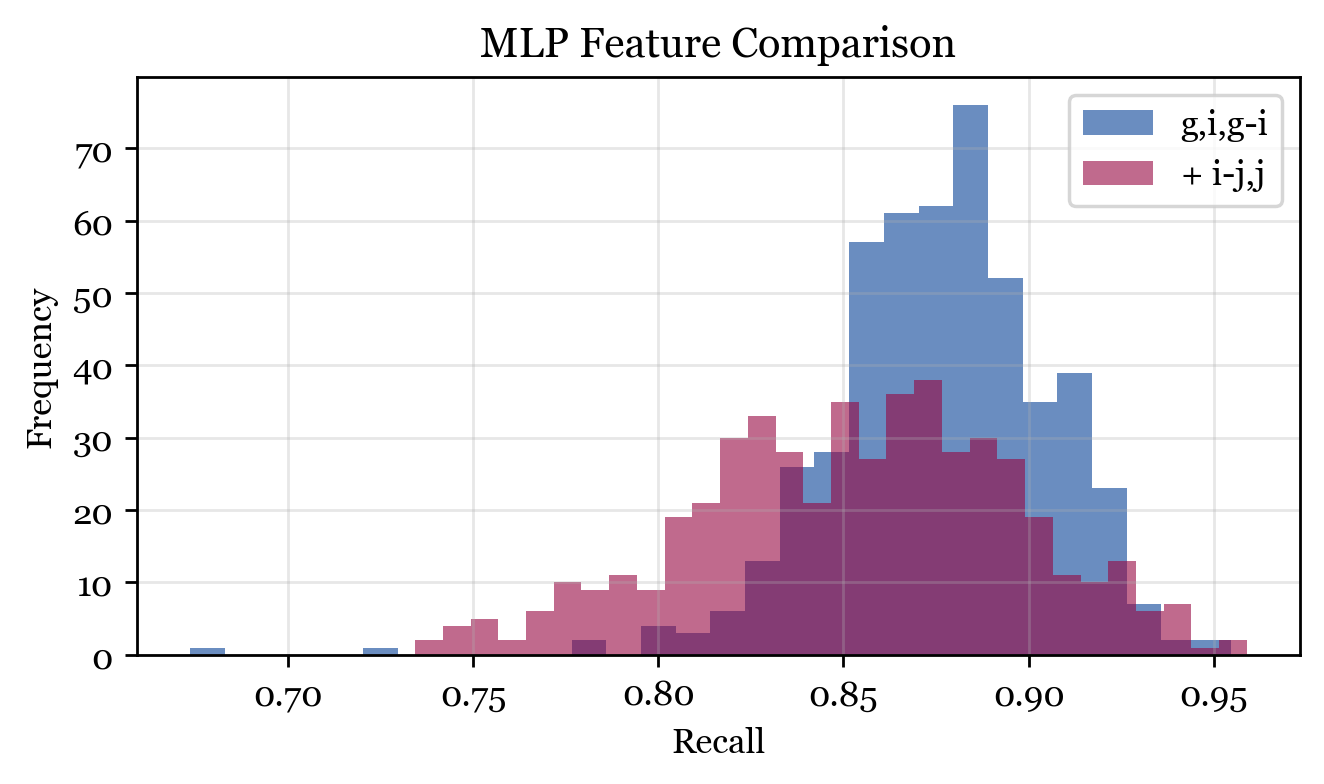

In [369]:
plt.figure(dpi=250, figsize=(6,3))
plt.hist(feat_recall[0],bins=30,color='#074297',alpha=0.6,label='g,i,g-i')
plt.hist(feat_recall[1],bins=30,color='#970742',alpha=0.6,label='+ i-j,j')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.title('MLP Feature Comparison')
plt.show()

In [321]:
#pickle.dump(feat_recall,open('pickle/temp/featcomparisonMLP2704.pk','wb'))

C:\Users\jwarn\AppData\Local\Temp\ipykernel_17276\650660136.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='pickle/temp/featcomparisonMLP2704.pk'>
  pickle.dump(feat_recall,open('pickle/temp/featcomparisonMLP2704.pk','wb'))


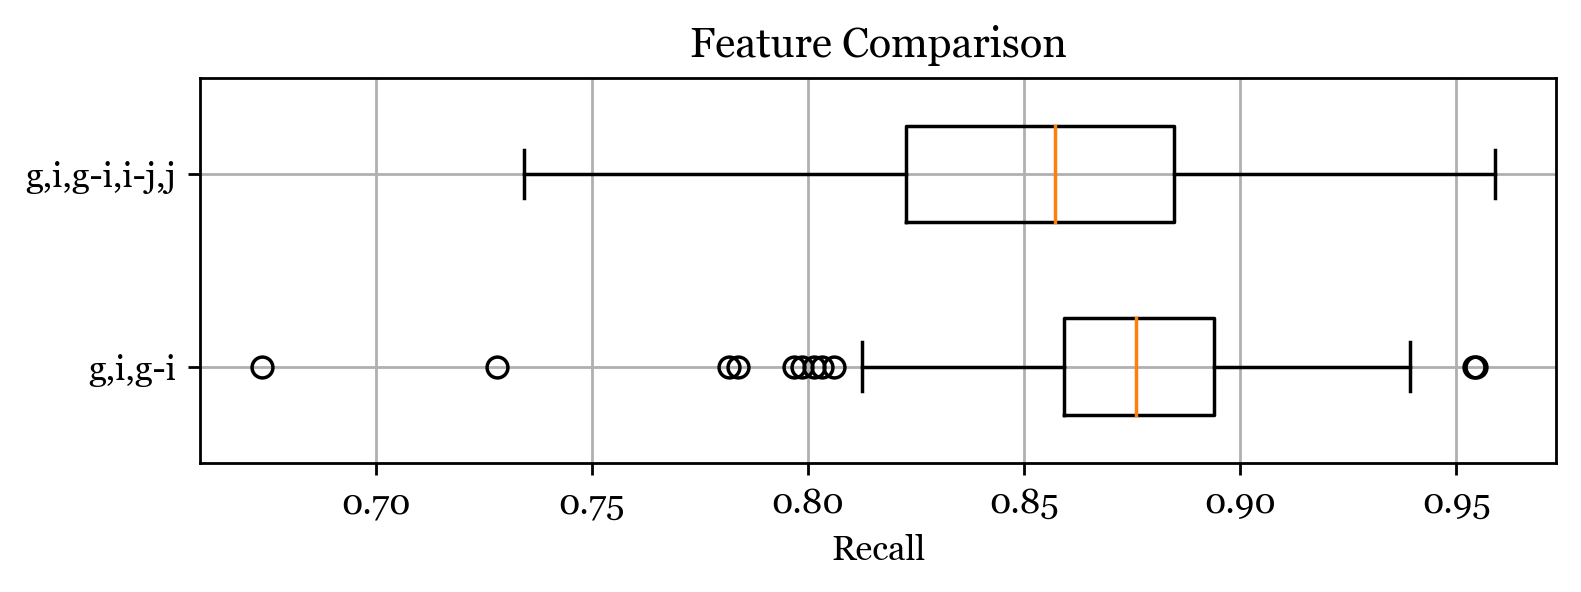

In [332]:
plt.figure(dpi=250, figsize=(7,2))
plt.boxplot([feat_recall[i] for i in feat_recall],labels=['g,i,g-i','g,i,g-i,i-j,j'],vert=False,widths=0.5)
plt.title('Feature Comparison')
plt.grid()
plt.xlabel('Recall')
plt.show()

### Plots

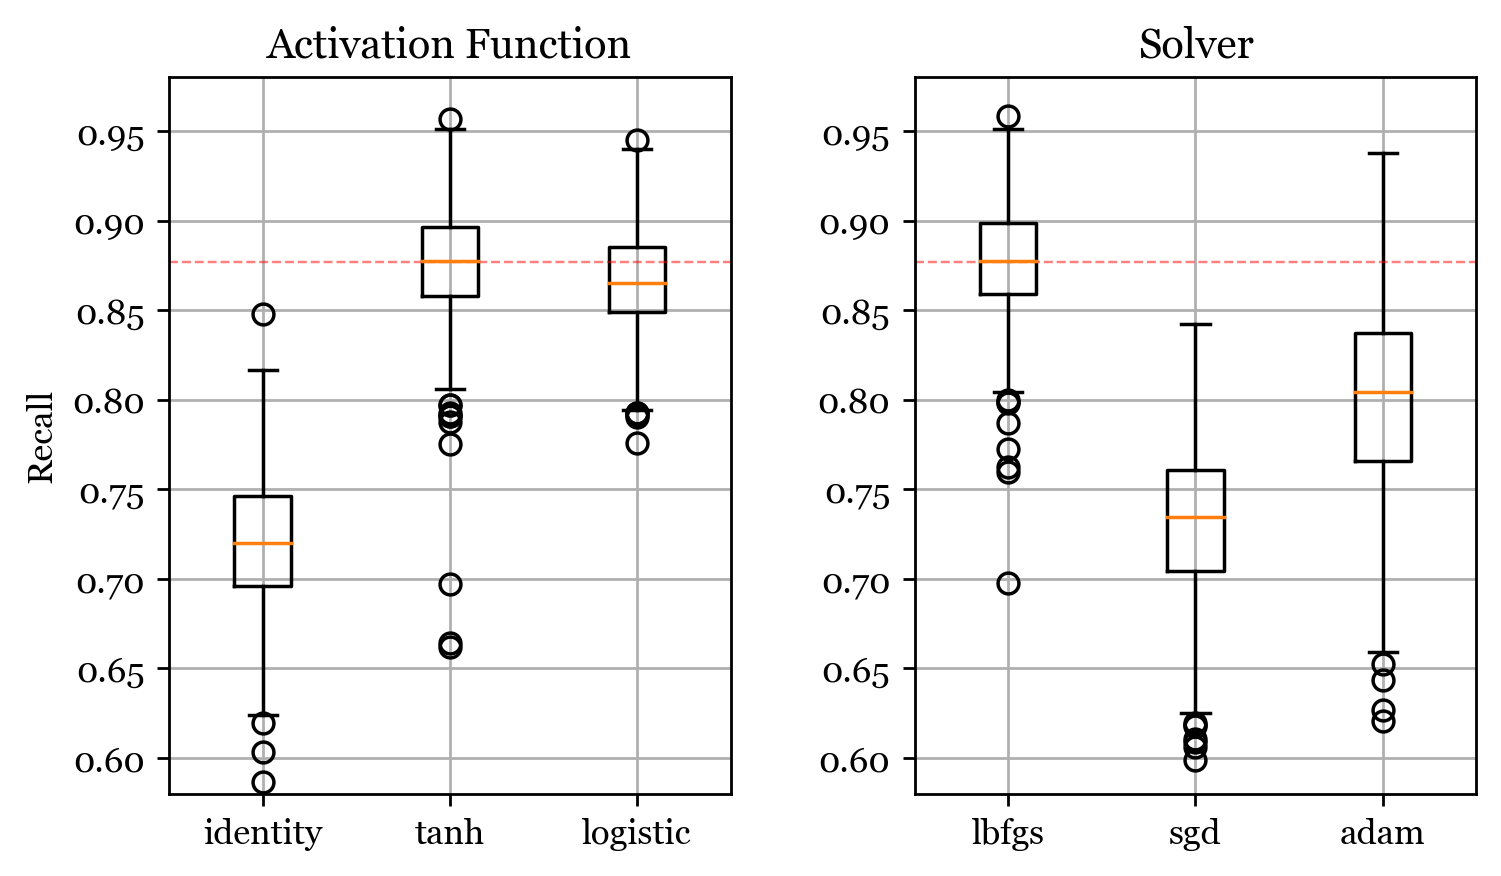

In [56]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6.5,4), dpi=250)

ax1.boxplot([ac_recall[i] for i in ac_recall],labels=activation)
ax2.boxplot([sol_recall[i] for i in sol_recall],labels=solvers)
ax1.set_title('Activation Function')
ax2.set_title('Solver')
ax1.grid(True)
ax2.grid(True)
ax1.set_ylabel('Recall')
ax1.set_ylim([0.58,0.98])
ax2.set_ylim([0.58,0.98])

ax1.axhline(0.877, c='r', linestyle='dashed', linewidth=0.7,alpha=0.5)
ax2.axhline(0.877, c='r', linestyle='dashed', linewidth=0.7,alpha=0.5)
fig.tight_layout(pad=2.5)


plt.show()

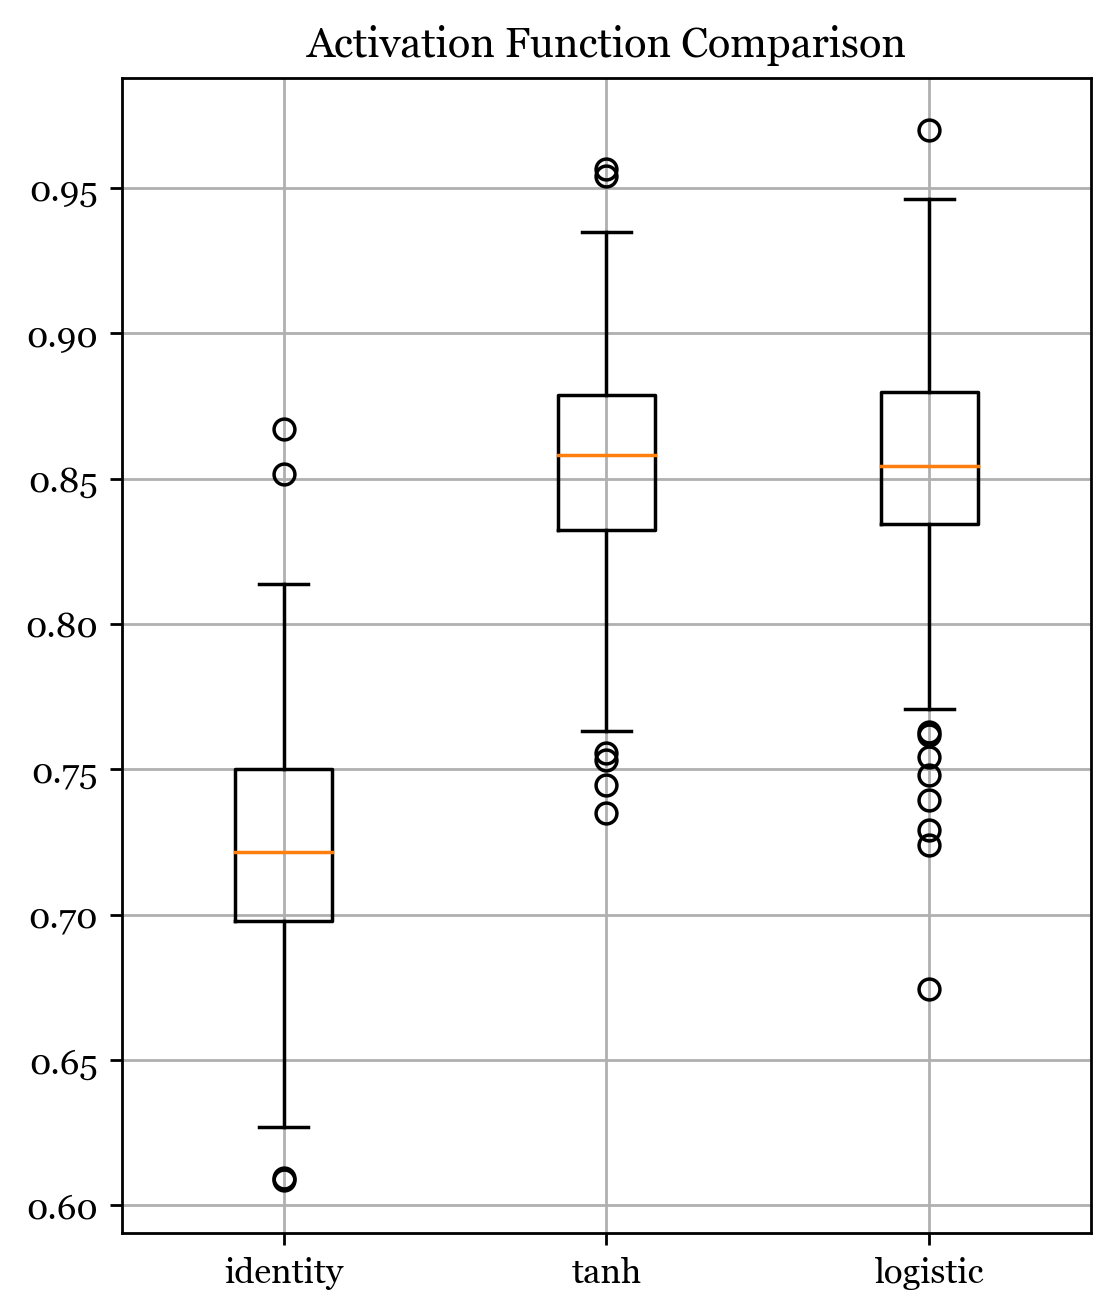

In [93]:
plt.figure(dpi=250, figsize=(5,6))
plt.boxplot([ac_recall[i] for i in ac_recall],labels=activation)
plt.title('Activation Function Comparison')
plt.grid()
plt.show()

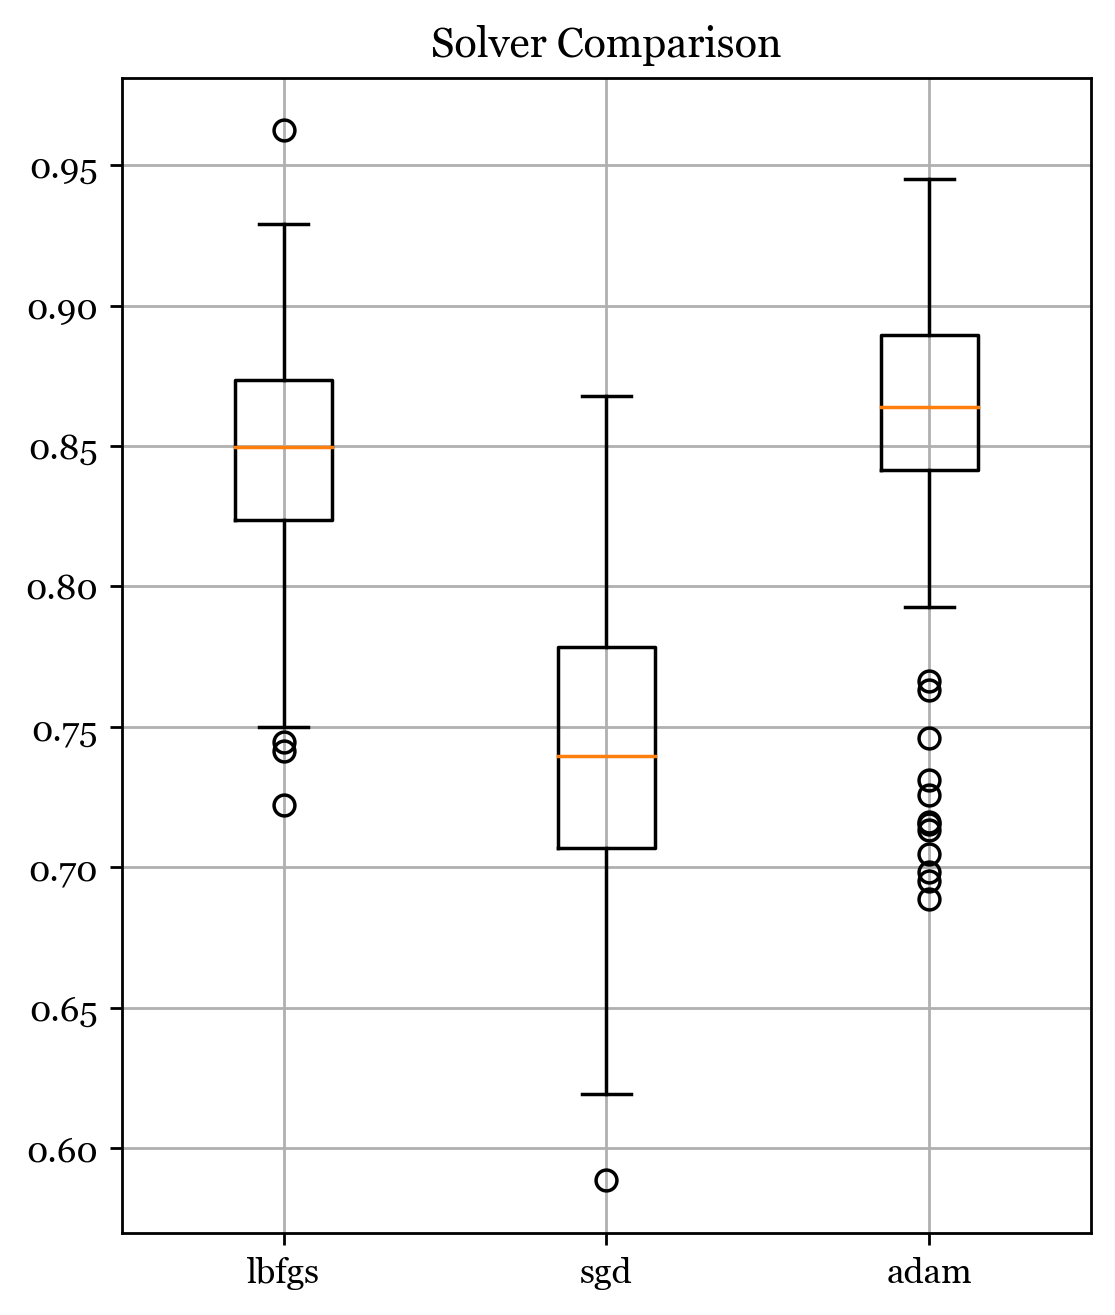

In [92]:
plt.figure(dpi=250, figsize=(5,6))
plt.boxplot([sol_recall[i] for i in sol_recall],labels=solvers)
plt.title('Solver Comparison')
plt.grid()
plt.show()

### Hidden Layers

In [124]:
# gather performance stats for mlp model
hidden_layer_sizes = [(2,),(3,),(4,),(2,2),(2,3),(3,2)]
hl_alpha = [1.2, 5, 8, 7, 8, 11]
hl_recall = {}
hl_accuracy = {}
for a,hs in enumerate(hidden_layer_sizes):
    print(hs)
    hl_recall[str(hs)] = []
    hl_accuracy[str(hs)] = []
    for i in range(500):
        _, test_pred, test_true, _, _ = mlp_class(training_data,solver='lbfgs',stats=True,
                                          max_iter=5000, alpha=hl_alpha[a], hidden_layer_sizes=hs)
    
        tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
        hl_recall[str(hs)].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        hl_accuracy[str(hs)].append( (tp+tn)/(tn+fp+fn+tp) )# fraction of correctly identified objects
        


(2,)
(3,)
(4,)
(2, 2)
(2, 3)
(3, 2)


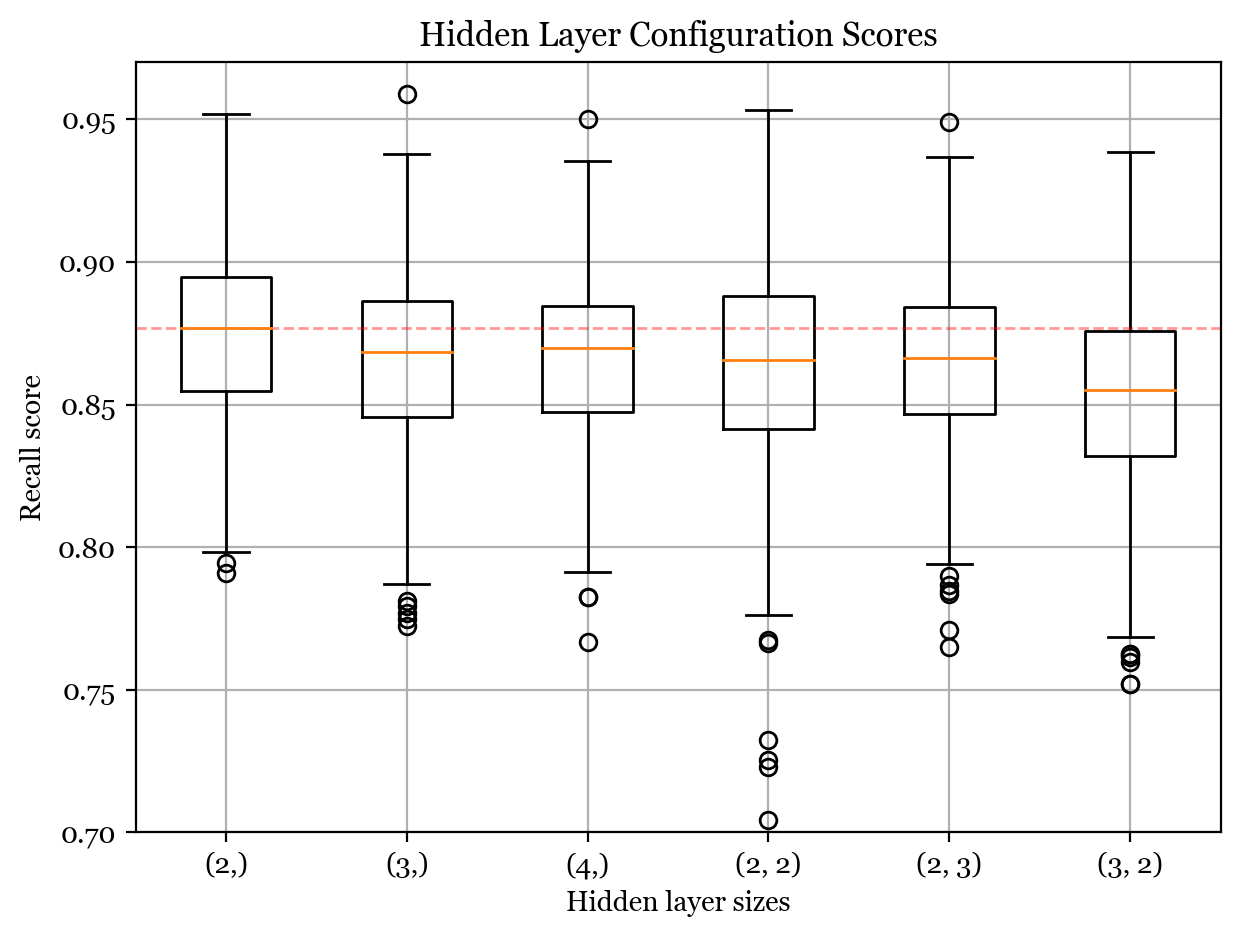

In [133]:
plt.figure(figsize=(7,5),dpi=200)
plt.boxplot([hl_recall[i] for i in hl_recall],labels=hidden_layer_sizes)
plt.grid()
plt.xlabel('Hidden layer sizes')
plt.ylabel('Recall score')
plt.title('Hidden Layer Configuration Scores')
plt.ylim([0.7,0.97])
plt.axhline(y=0.877, linewidth=1, linestyle='dashed', c='r', alpha=0.4)
plt.show()

## MLP WITH 2MASS

In [217]:
training_data2m = training_data[training_data['2mass_acc']==True]

In [218]:
training_data2m

,obj_id,class,i,g,g-i,di,dg,ra,dec,field,pdidx,rbcidx,nearby,j,h,k,ph_qual,2mass_acc,i-j
1,C30,galaxy,18.049000,19.500999,1.452000,0.001,0.002,12.105896,29.267633,11,118854,2431,24,15.869,15.216,14.756,AAB,True,2.180000
2,LAMOST-C22,galaxy,17.628000,19.153000,1.525000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,15.251,14.503,13.918,AAA,True,2.377000
4,LAMOST-C18,galaxy,17.177999,18.388000,1.210001,0.001,0.001,23.842129,29.552473,14,122860,2644,12,14.838,14.277,13.847,AAA,True,2.339999
7,LAMOST-2,galaxy,18.441000,19.237000,0.796000,0.002,0.002,24.075237,30.274384,24,190425,2651,22,16.746,15.969,15.708,BCC,True,1.695000
9,LAMOST-C16,galaxy,17.121000,18.371000,1.250000,0.001,0.001,25.115274,30.627903,24,99155,2654,14,14.681,13.909,13.669,AAA,True,2.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,SD-GC7,gc,17.462000,18.429001,0.967001,0.001,0.001,8.092500,48.524174,395,112894,64,85,15.667,15.041,15.025,AAB,True,1.795000
1319,PA-N147-1,gc,17.424000,18.291000,0.867001,0.001,0.001,8.147034,48.329792,395,218780,66,120,15.735,15.131,14.939,AAA,True,1.689000
1324,Hodge-III,gc,17.572001,18.465000,0.893000,0.001,0.001,8.313167,48.456367,395,60636,75,192,15.574,14.916,14.999,AAA,True,1.998001
1325,FJJ-VIII,gc,17.910999,18.806000,0.895000,0.001,0.001,9.848991,48.312565,398,168456,385,134,16.127,15.516,15.458,ABC,True,1.783999


## Random Forest Parameter Varying Functions

    def ranfor(df,train_size=0.8,n_estimators=50,criterion='gini',features=['i','g','g-i'], max_depth=None, 
           max_leaf_nodes=None, min_samples_leaf=1, stats=False):

In [72]:
time()

1682524375.8277037

In [345]:
# gather performance stats for mlp model
criterion = ['gini','entropy']

recall = {}
accuracy = {}
for s in criterion:
    t1 = time()
    recall[s] = []
    accuracy[s] = []
    for i in range(300):
        _, test_pred, test_true, _, _ = ranfor(training_data,criterion=s,stats=True)
    
        tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
        recall[s].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        accuracy[s].append( (tp+tn)/(tn+fp+fn+tp) )# fraction of correctly identified objects
        
    print(time()-t1)

30.527640342712402
31.18745470046997


In [373]:
all_things={'mlp_feat': feat_recall,'hid_lay': hl_recall, 'rf_crit':recall}

In [374]:
pickle.dump(all_things,open('./pickle/temp/everything2704.pk','wb'))

C:\Users\jwarn\AppData\Local\Temp\ipykernel_17276\2727587633.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='./pickle/temp/everything2704.pk'>
  pickle.dump(all_things,open('./pickle/temp/everything2704.pk','wb'))


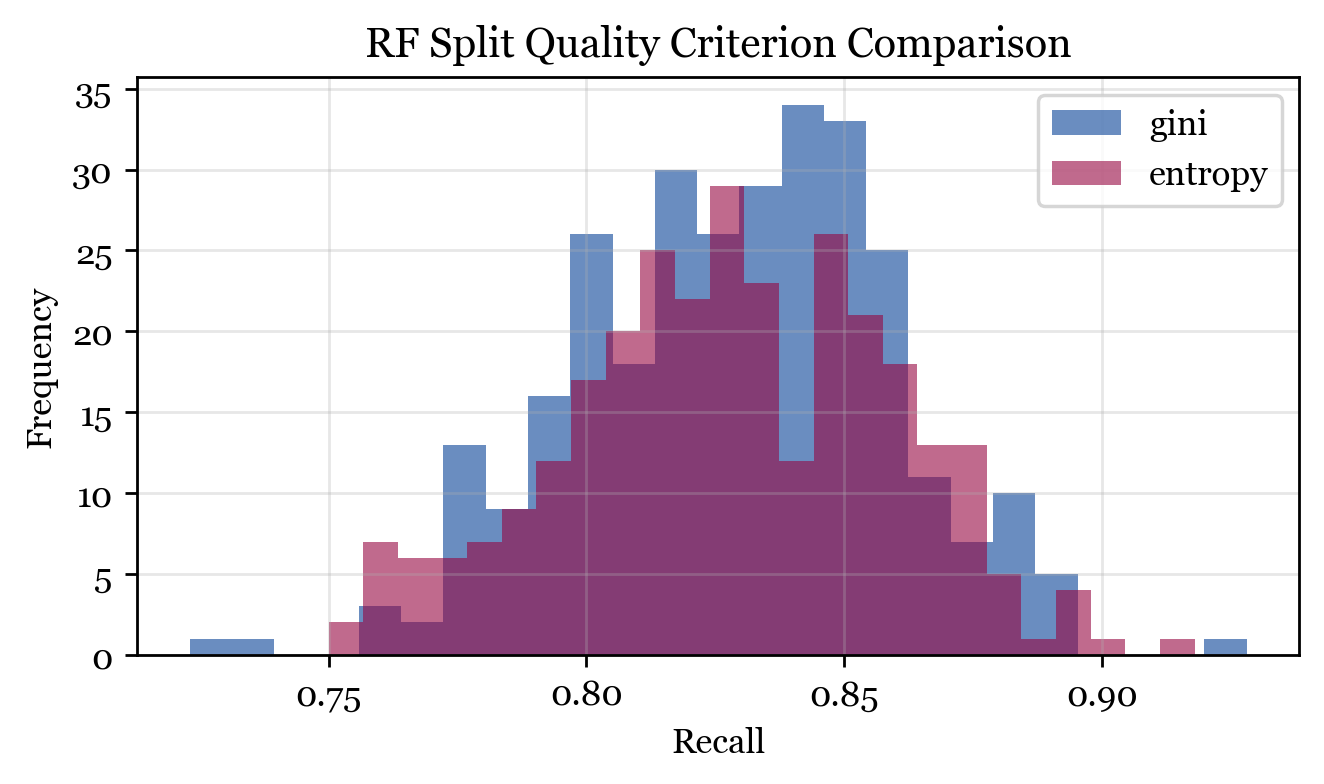

In [372]:
plt.figure(dpi=250, figsize=(6,3))
plt.hist(recall['gini'],bins=25,color='#074297',alpha=0.6,label='gini')
plt.hist(recall['entropy'],bins=25,color='#970742',alpha=0.6,label='entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.title('RF Split Quality Criterion Comparison')
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.show()

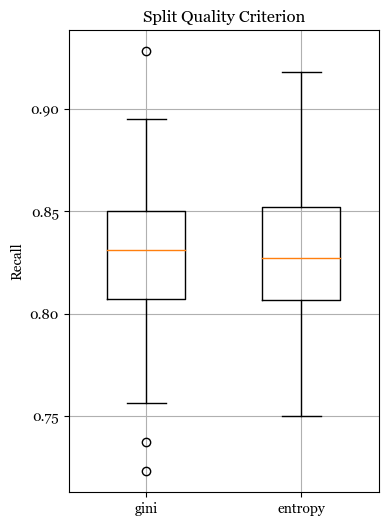

In [365]:
plt.figure(figsize=(4,6),dpi=100)
plt.boxplot([recall[i] for i in recall],labels=criterion,widths=0.5)
plt.grid()
plt.ylabel('Recall')
plt.title('Split Quality Criterion')
plt.show()

In [56]:
def rf_vary_trees(n_estimators_range: range, iterations: int, max_leaf_nodes=None, max_depth=None,min_samples_leaf=1, features=['i','g','g-i']) -> dict:
    stats = {}
    for n in n_estimators_range:
        print(f'calculating for {n} trees...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = ranfor(training_data,n_estimators=n,features=features,min_samples_leaf=min_samples_leaf,
                                   max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, stats=True)[1:]
            stats = stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

def rf_vary_max_leaf_nodes(max_leaf_range: range, iterations: int, n_estimators=50, max_depth=None,min_samples_leaf=1, features=['i','g','g-i']) -> dict:
    stats = {}
    for n in max_leaf_range:
        print(f'calculating max leaf nodes {n}...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = ranfor(training_data,n_estimators=n_estimators,features=features,min_samples_leaf=min_samples_leaf,
                                   max_depth=max_depth, max_leaf_nodes=n, stats=True)[1:]
            stats = stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

def rf_vary_min_samples_leaf(min_samples_range: list, iterations: int, n_estimators=50, max_leaf_nodes=None, max_depth=None, features=['i','g','g-i']) -> dict:
    stats = {}
    for n in min_samples_range:
        print(f'calculating min samples {n}...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = ranfor(training_data,n_estimators=n_estimators,features=features,
                                   max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=n, stats=True)[1:]
            stats = stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

def rf_vary_max_depth(max_depth_range: range, iterations: int, n_estimators=50, max_leaf_nodes=None,min_samples_leaf=1, features=['i','g','g-i']) -> dict:
    stats = {}
    for n in max_depth_range:
        print(f'calculating max depth {n}...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = ranfor(training_data,n_estimators=n_estimators,features=features,min_samples_leaf=min_samples_leaf,
                                   max_depth=n, max_leaf_nodes=max_leaf_nodes, stats=True)[1:]
            stats = stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

## Random Forest Parameter Tuning

In [200]:
training_data

,obj_id,class,i,g,g-i,di,dg,ra,dec,field,pdidx,rbcidx,nearby,j,h,k,ph_qual,2mass_acc
0,HM33-A,gc,22.424000,22.940001,0.516001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,13.028,12.881,12.805,AAA,False
1,C30,galaxy,18.049000,19.500999,1.452000,0.001,0.002,12.105896,29.267633,11,118854,2431,24,15.869,15.216,14.756,AAB,True
2,LAMOST-C22,galaxy,17.628000,19.153000,1.525000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,15.251,14.503,13.918,AAA,True
3,HM33-B,gc,19.538000,20.386000,0.848000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,16.429,15.589,15.154,BBC,False
4,LAMOST-C18,galaxy,17.177999,18.388000,1.210001,0.001,0.001,23.842129,29.552473,14,122860,2644,12,14.838,14.277,13.847,AAA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,PA-N185,gc,20.188000,21.688999,1.500999,0.005,0.007,9.578100,48.367985,398,256376,306,106,11.881,11.436,11.314,AAA,False
1330,FJJ-V,gc,17.434999,18.451000,1.016001,0.001,0.001,9.806167,48.384743,398,168423,372,156,13.321,12.966,12.889,AAA,False
1331,FJJ-VII,gc,19.523001,20.520000,0.997000,0.003,0.004,9.826713,48.384266,398,168594,377,163,14.687,14.317,14.254,AAA,False
1332,PA-N147-3,gc,19.910000,20.820999,0.910999,0.004,0.004,8.542029,49.044243,402,101369,91,36,14.378,13.857,13.694,AAA,False


In [295]:
trees_range = [5,10,15,20,30,40]
min_samples_split_range = [0.005,0.01,0.015,0.02,0.03,0.05,]
max_depth_range = [2,3,4,5,7,10,12,15]
max_features = [2]

In [296]:
#with open('./pickle/1005scores.pk','wb') as f:
#    pickle.dump((scores,search_space),f)

In [297]:
from itertools import product
search_space = np.array(list(product(trees_range, min_samples_split_range, max_depth_range, max_features)))
print(len(search_space), 'parameter combinations')

288 parameter combinations


In [299]:
from sklearn.model_selection import cross_val_score
n_trees = 50
features=['i','g','g-i']
max_leaf_nodes = None
min_samples_leaf = 2
max_depth = 10
df = training_data

scores = {}
for i, config in enumerate(search_space):
    t = time()
    n_estimators, min_samples_split, max_depth, max_features = config
    clf = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=max_depth,
                                    criterion='gini', max_leaf_nodes=max_leaf_nodes,
                                    min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_jobs=-1)
    X = df[features]
    y = df['class']
    scores[i] = cross_val_score(clf, X, y, cv=10)
    print(f'For configuration {i} : {config}:\n\t {scores[i].mean():.4f} accuracy with std of {scores[i].std():.4f}')
    print(f'\tTTE: {time()-t}')

For configuration 0 : [5.    0.005 2.    2.   ]:
	 0.8135 accuracy with std of 0.0637
	TTE: 11.375189304351807
For configuration 1 : [5.    0.005 3.    2.   ]:
	 0.8233 accuracy with std of 0.0731
	TTE: 0.1515941619873047
For configuration 2 : [5.    0.005 4.    2.   ]:
	 0.8202 accuracy with std of 0.0677
	TTE: 0.15857601165771484
For configuration 3 : [5.    0.005 5.    2.   ]:
	 0.8262 accuracy with std of 0.0653
	TTE: 0.15424299240112305
For configuration 4 : [5.e+00 5.e-03 7.e+00 2.e+00]:
	 0.8225 accuracy with std of 0.0542
	TTE: 0.15957188606262207
For configuration 5 : [5.e+00 5.e-03 1.e+01 2.e+00]:
	 0.8269 accuracy with std of 0.0550
	TTE: 0.16655969619750977
For configuration 6 : [5.0e+00 5.0e-03 1.2e+01 2.0e+00]:
	 0.8059 accuracy with std of 0.0572
	TTE: 0.15608882904052734
For configuration 7 : [5.0e+00 5.0e-03 1.5e+01 2.0e+00]:
	 0.8165 accuracy with std of 0.0562
	TTE: 0.14960002899169922
For configuration 8 : [5.   0.01 2.   2.  ]:
	 0.7970 accuracy with std of 0.0850


For configuration 73 : [10.    0.02  3.    2.  ]:
	 0.8180 accuracy with std of 0.0760
	TTE: 0.25232434272766113
For configuration 74 : [10.    0.02  4.    2.  ]:
	 0.8262 accuracy with std of 0.0737
	TTE: 0.24998879432678223
For configuration 75 : [10.    0.02  5.    2.  ]:
	 0.8218 accuracy with std of 0.0708
	TTE: 0.24135518074035645
For configuration 76 : [10.    0.02  7.    2.  ]:
	 0.8247 accuracy with std of 0.0650
	TTE: 0.25531792640686035
For configuration 77 : [10.    0.02 10.    2.  ]:
	 0.8240 accuracy with std of 0.0602
	TTE: 0.24534821510314941
For configuration 78 : [10.    0.02 12.    2.  ]:
	 0.8195 accuracy with std of 0.0600
	TTE: 0.23851299285888672
For configuration 79 : [10.    0.02 15.    2.  ]:
	 0.8210 accuracy with std of 0.0615
	TTE: 0.24036049842834473
For configuration 80 : [10.    0.03  2.    2.  ]:
	 0.7721 accuracy with std of 0.0955
	TTE: 0.23415827751159668
For configuration 81 : [10.    0.03  3.    2.  ]:
	 0.8195 accuracy with std of 0.0736
	TTE: 0.2

For configuration 144 : [2.e+01 5.e-03 2.e+00 2.e+00]:
	 0.8225 accuracy with std of 0.0812
	TTE: 0.3647949695587158
For configuration 145 : [2.e+01 5.e-03 3.e+00 2.e+00]:
	 0.8157 accuracy with std of 0.0720
	TTE: 0.3744969367980957
For configuration 146 : [2.e+01 5.e-03 4.e+00 2.e+00]:
	 0.8270 accuracy with std of 0.0786
	TTE: 0.37400269508361816
For configuration 147 : [2.e+01 5.e-03 5.e+00 2.e+00]:
	 0.8315 accuracy with std of 0.0632
	TTE: 0.3759944438934326
For configuration 148 : [2.e+01 5.e-03 7.e+00 2.e+00]:
	 0.8255 accuracy with std of 0.0717
	TTE: 0.3675243854522705
For configuration 149 : [2.e+01 5.e-03 1.e+01 2.e+00]:
	 0.8239 accuracy with std of 0.0620
	TTE: 0.37400341033935547
For configuration 150 : [2.0e+01 5.0e-03 1.2e+01 2.0e+00]:
	 0.8247 accuracy with std of 0.0653
	TTE: 0.3717823028564453
For configuration 151 : [2.0e+01 5.0e-03 1.5e+01 2.0e+00]:
	 0.8292 accuracy with std of 0.0580
	TTE: 0.3730044364929199
For configuration 152 : [2.e+01 1.e-02 2.e+00 2.e+00]:

For configuration 214 : [3.0e+01 1.5e-02 1.2e+01 2.0e+00]:
	 0.8225 accuracy with std of 0.0746
	TTE: 0.5580418109893799
For configuration 215 : [3.0e+01 1.5e-02 1.5e+01 2.0e+00]:
	 0.8255 accuracy with std of 0.0596
	TTE: 0.6129441261291504
For configuration 216 : [3.e+01 2.e-02 2.e+00 2.e+00]:
	 0.8090 accuracy with std of 0.0739
	TTE: 0.5365643501281738
For configuration 217 : [3.e+01 2.e-02 3.e+00 2.e+00]:
	 0.8225 accuracy with std of 0.0784
	TTE: 0.5944108963012695
For configuration 218 : [3.e+01 2.e-02 4.e+00 2.e+00]:
	 0.8307 accuracy with std of 0.0734
	TTE: 0.5663089752197266
For configuration 219 : [3.e+01 2.e-02 5.e+00 2.e+00]:
	 0.8270 accuracy with std of 0.0735
	TTE: 0.6163556575775146
For configuration 220 : [3.e+01 2.e-02 7.e+00 2.e+00]:
	 0.8195 accuracy with std of 0.0741
	TTE: 0.5497465133666992
For configuration 221 : [3.e+01 2.e-02 1.e+01 2.e+00]:
	 0.8180 accuracy with std of 0.0662
	TTE: 0.5576338768005371
For configuration 222 : [3.0e+01 2.0e-02 1.2e+01 2.0e+00

For configuration 285 : [40.    0.05 10.    2.  ]:
	 0.8255 accuracy with std of 0.0805
	TTE: 0.6532723903656006
For configuration 286 : [40.    0.05 12.    2.  ]:
	 0.8248 accuracy with std of 0.0805
	TTE: 0.6373012065887451
For configuration 287 : [40.    0.05 15.    2.  ]:
	 0.8187 accuracy with std of 0.0739
	TTE: 0.6443066596984863


In [300]:
means = [scores[i].mean() for i in scores]

In [308]:
np.argmax(means)

242

In [307]:
means[np.argmax(means)]

0.8389967455953314

In [310]:
5e-3

0.005

In [309]:
search_space[np.argmax(means)]

array([4.e+01, 5.e-03, 4.e+00, 2.e+00])

In [280]:
means[561]

0.8209796880260353

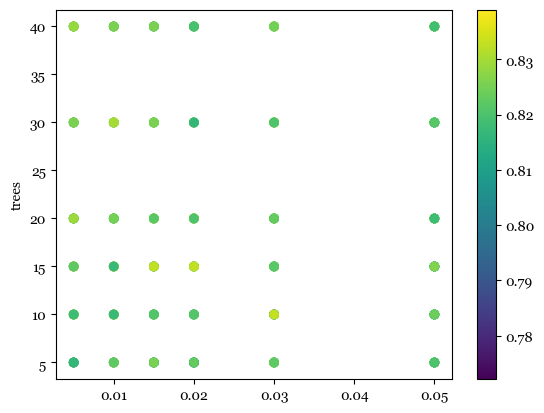

In [305]:
plt.scatter(search_space[:,1],search_space[:,0],c=means)
plt.ylabel('trees')
plt.colorbar()

In [ ]:
def ranfor(df,train_size=0.8,n_estimators=50,criterion='gini',features=['i','g','g-i'], max_depth=None, 
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, stats=False
           
           return ran_for_class, test_pred, y_test, train_pred, y_train

# Read region files back in
... and match them to the original CAT file for adding back to the training set  
started working on 20/02

In [53]:
# reads a region file and returns a list of coordinates for every point listed within
# note: the path parameter must be the path starting in the root directory (e.g. path='ds9_regions/folder/region.reg')
#      otherwise, the field parameter will look for the file 'ds9_regions/predictions/FIELD_predictions.reg'
# note: region file must be formatted with the first two lines defining the settings and coordinate system,
#       with the third line beginning the list of circle(x,y) or point(x,y)
def read_reg(field: int, path=None) -> list:
    if path is None:
        path = f'ds9_regions/predictions/{field}_predictions.reg'
    try:
        with open(path,'r') as f:
            reg_file_lines = f.readlines()[2:] # skip the first two lines
    except FileNotFoundError:
        print("Please enter a full path to the file from the current directory, or choose a field that has a predictions region file.")
        return 0
    
    ret = []
    for i in range(len(reg_file_lines)):
        coords = reg_file_lines[i].split('(')[1].split(',')[0:2] # split at the first open bracket, split along, commas, choose the first two values (the coordinates)
        ra = float(coords[0])
        dec = float(coords[1])
        ret.append((ra,dec))
    return ret

In [14]:
# takes a list of coordinates and field, and returns a list of values to add to training data
def get_data_from_coords(field: int, coords: list) -> list:
    cat = load_cat(field)[field]
    ret = []
    for c in coords:
        row = cat[(cat['RA']==c[0]) & (cat['Dec']==c[1])][0]
        i, g = row['i'], row['g']
        di, dg = row['di'], row['dg']
        g_i = g-i
        ra, dec = c
        # pdidx = # need to find a way of extracting the pandas index
        vals = (i,g,di,dg,ra,dec,field,g_i) # values for relevant columns in training
        ret.append(vals)
    return ret

In [15]:
# takes the training dataset and a list of values to add to it and returns a new dataframe with the added values
def add_nongc_to_training(train_df: pd.DataFrame, vals: list, nongc_class='galaxy') -> pd.DataFrame:
    # make dataframe from values
    columns = ['i','g','di','dg','ra','dec','field','g-i']
    add_df = pd.DataFrame(vals,columns=columns)
    add_df['obj_id'] = 'none'
    add_df['class'] = nongc_class
    add_df['pdidx'] = 0
    add_df['rbcidx'] = 0
    add_df['nearby'] = 0
    
    new_df = pd.concat([train_df, add_df],ignore_index=True, verify_integrity=True,copy=False)
    return new_df

In [16]:
def update_training_data(field:int, path=None, train_df=training_data, nongc_class='galaxy') -> pd.DataFrame:
    coords = read_reg(field, path=path)
    vals = get_data_from_coords(field,coords)
    new_training_data = add_nongc_to_training(train_df,vals,nongc_class=nongc_class)
    return new_training_data

# 10/03 Reading reg files in to capture crowded predictions
Crowded predictions signify a relevant point such as the examples shown below (with 16 arcsec circles):  
<img src='./img/globularclusteredpredictions207.1.png' width=450>
<img src='./img/globularclusteredpredictions207.3.png' width=450>
<img src='./img/globularclusteredpredictions207.7.png' width=450>

# DBSCAN

In [17]:
from sklearn.cluster import DBSCAN

In [18]:
fields = [135,148,163,178,208,207,229,222,273,274]
f_i = 0

In [19]:
f_i+=1
f_i

1

In [20]:
# read in region file
field = fields[f_i]
field = 207
date = '1303'
points = read_reg(field, path=f'./ds9_regions/predictions/{date}/{field}_predictions.reg')

In [22]:
# set boundaries to search in
x1,x2 = (8.35,8.47)
y1,y2 = (39.48,39.58)

working_pts = [p for p in points if ((x1<p[0]<x2) and (y1<p[1]<y2))]
working_pts=points

In [18]:
fields = [135,148,163,178,208,207,229,222,273,274]
f_i = 0

In [19]:
f_i+=1
f_i

1

In [23]:
# set dbscan parameters
eps = 0.005
min_samples = 4
leaf_size = 30
n_jobs = 1

# apply dbscan to the set of points
clustering = DBSCAN(eps=eps,min_samples=min_samples, metric='euclidean',
       metric_params=None, algorithm='auto', leaf_size=leaf_size, p=None, n_jobs=n_jobs).fit(working_pts)

# seperate points into their individual clusters
cluster_labels = clustering.labels_
clusters = {}

for i in range(len(working_pts)):
    lbl = cluster_labels[i]
    if lbl == -1: continue # skip the non clustered points
    if lbl in clusters:
        clusters[lbl].append(working_pts[i])
    else:
        clusters[lbl] = [working_pts[i]]
print(len(clusters))

22


In [24]:
clusters

{0: [(8.712679, 39.545162),
  (8.718629, 39.544273),
  (8.718521, 39.542015),
  (8.715775, 39.54709),
  (8.714812, 39.545647),
  (8.709954, 39.544704),
  (8.713062, 39.541767),
  (8.703762, 39.54412),
  (8.715287, 39.54267),
  (8.705625, 39.54378),
  (8.720887, 39.545788),
  (8.708779, 39.54205),
  (8.713979, 39.542713),
  (8.720692, 39.54571),
  (8.712904, 39.547287),
  (8.704166, 39.54635),
  (8.721467, 39.5468),
  (8.719658, 39.54739)],
 1: [(8.633954, 39.634518),
  (8.630484, 39.636612),
  (8.632367, 39.63537),
  (8.635113, 39.636295),
  (8.631687, 39.635757)],
 2: [(8.59055, 39.60146),
  (8.588887, 39.601654),
  (8.590758, 39.602478),
  (8.594008, 39.600857),
  (8.593667, 39.60145),
  (8.590058, 39.602657),
  (8.58538, 39.601883),
  (8.586263, 39.601776),
  (8.594454, 39.601315),
  (8.595242, 39.600517),
  (8.584254, 39.60341),
  (8.58105, 39.60276),
  (8.581225, 39.601257)],
 3: [(8.47075, 39.601776),
  (8.470271, 39.601753),
  (8.467025, 39.599747),
  (8.466988, 39.59796)],
 4: 

In [25]:
coords = [[[clusters[lbl][i][a] for i in range(len(clusters[lbl]))] for lbl in clusters] for a in [0,1]]
ra = []
dec = []
for l in coords[0]:
    ra += l
for l in coords[1]:
    dec += l

from pathlib import Path
date = 1303

Path(f'./pickle/predictions/{date}').mkdir(parents=True, exist_ok=True)

coord_table = QTable((ra,dec),names=['RA','Dec'])
with open(f'./pickle/predictions/{date}/predictionsf{field}_clusters.pk','wb') as f:
    pickle.dump(coord_table, f)

In [26]:
plt.scatter(*zip(*clusters[l]), s=5)

TypeError: unhashable type: 'list'

In [47]:
# match objects in clusters to PAndAS
# matches every object from CAT[n] so the resulting arrays are len(CAT[n]) long
def match_objs(field:int, cluster:list) -> (np.ndarray, np.ndarray):
    d1 = cluster
    ra_obs, dec_obs = [c[0] for c in cluster], [c[1] for c in cluster]
    d2 = load_cat(field)[field]
    ra_qry, dec_qry = d2['RA'], d2['Dec']

    c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
    c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
    idx, _, _ = c1.match_to_catalog_sky(c2)
    return idx #idx: the index of the object in RBC, d2d: distance to that object from CAT

In [45]:
cluster_matches = match_objs(field, clusters[0])

In [46]:
clusters[0]

[(8.712679, 39.545162),
 (8.718629, 39.544273),
 (8.718521, 39.542015),
 (8.715775, 39.54709),
 (8.714812, 39.545647),
 (8.709954, 39.544704),
 (8.713062, 39.541767),
 (8.703762, 39.54412),
 (8.715287, 39.54267),
 (8.705625, 39.54378),
 (8.720887, 39.545788),
 (8.708779, 39.54205),
 (8.713979, 39.542713),
 (8.720692, 39.54571),
 (8.712904, 39.547287),
 (8.704166, 39.54635),
 (8.721467, 39.5468),
 (8.719658, 39.54739)]

In [39]:
cluster_matches

array([70821, 70826, 70835, 70866, 71000, 71006, 71037, 71081, 71101,
       71107, 71124, 71165, 71166, 71171, 71192, 71434, 71748, 71813],
      dtype=int64)

In [42]:
cat = load_cat(field)[field]

In [43]:
cluster_rows = cat[cluster_matches]

In [44]:
cluster_rows

RA,Dec,iccd,xg,yg,g,dg,ig,xi,yi,i,di,ii,ia,field
float32,float32,uint8,float32,float32,float32,float32,int8,float32,float32,float32,float32,int8,int8,uint16
8.712679,39.545162,3,1577.8,3011.89,20.345,0.003,1,1565.62,3040.74,19.783,0.003,1,0,207
8.718629,39.544273,3,1666.73,3028.55,20.419,0.003,1,1654.53,3057.34,20.404,0.005,1,0,207
8.718521,39.542015,3,1665.11,3072.55,20.579,0.003,1,1652.92,3101.34,20.744,0.007,1,0,207
8.715775,39.54709,3,1624.08,2974.22,20.954,0.004,1,1611.88,3003.05,20.942,0.008,1,0,207
8.714812,39.545647,3,1609.71,3002.33,22.105,0.008,1,1597.52,3031.16,21.24,0.01,1,0,207
8.709954,39.544704,3,1537.12,3021.16,22.118,0.008,1,1524.94,3049.96,21.485,0.012,1,0,207
8.713062,39.541767,3,1583.52,3077.91,22.29,0.009,1,1571.35,3106.72,22.429,0.026,1,0,207
8.703762,39.54412,3,1444.6,3033.3,22.502,0.011,1,1432.45,3062.03,22.561,0.029,1,0,207
8.715287,39.54267,3,1616.76,3060.03,22.598,0.012,1,1604.58,3088.81,22.682,0.032,1,0,207


Text(0, 0.5, 'g-i')

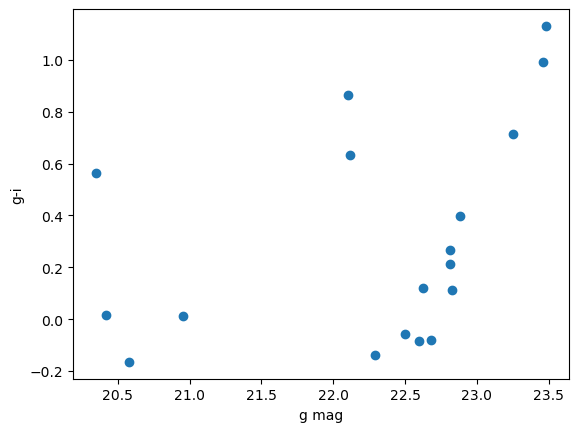

In [48]:
plt.scatter(cluster_rows['g'],cluster_rows['g']-cluster_rows['i'])
plt.xlabel('g mag')
plt.ylabel('g-i')

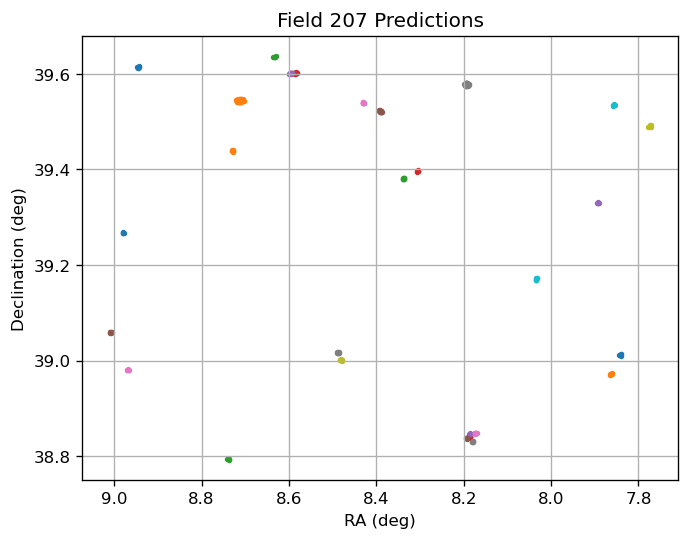

In [53]:
# plot clusters
plt.figure(dpi=120)

for l in clusters:
    plt.scatter(*zip(*clusters[l]), s=5)

#plt.xlim([x1,x2])
#plt.ylim([y1,y2])
plt.grid()
plt.xlabel('RA (deg)')
plt.ylabel('Declination (deg)')
plt.title(f"Field {field} Predictions")
plt.gca().invert_xaxis()

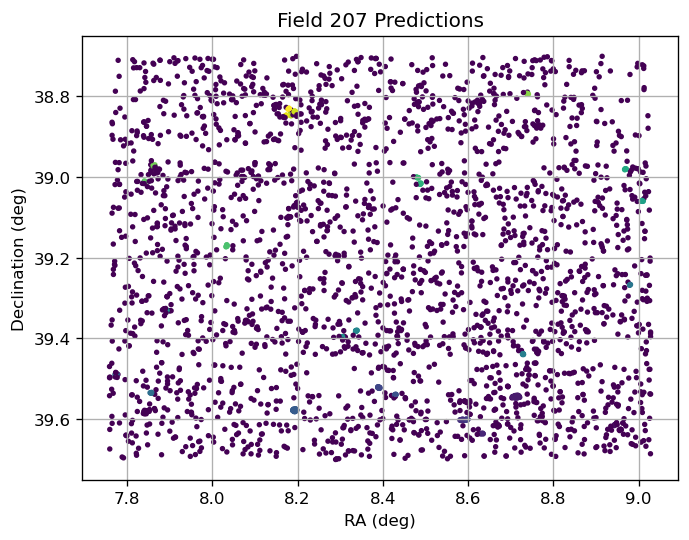

In [21]:
plt.figure(dpi=120)
plt.scatter(*zip(*working_pts), s=5, c=clustering.labels_)
#plt.xlim([x1,x2])
#plt.ylim([y1,y2])
plt.grid()
plt.xlabel('RA (deg)')
plt.ylabel('Declination (deg)')
plt.title(f"Field {field} Predictions")
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

### Testing loading new train data from regions

In [16]:
training_data

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106,-1.500999
1330,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156,-1.016001
1331,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163,-0.997000
1332,PA-N147-3,gc,19.910000,20.820999,0.004,0.004,8.542029,49.044243,402,101369,91,36,-0.910999


In [17]:
new_train = update_training_data(21)

In [19]:
new_train

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,none,galaxy,22.718000,23.495001,0.028,0.020,11.801250,30.054356,21,0,0,0,-0.777000
2208,none,galaxy,22.591000,23.504999,0.026,0.021,11.916008,29.841837,21,0,0,0,-0.914000
2209,none,galaxy,22.568001,23.559999,0.025,0.021,11.916621,29.989470,21,0,0,0,-0.991999
2210,none,galaxy,22.615999,23.528000,0.026,0.021,11.903784,29.837309,21,0,0,0,-0.912001


In [140]:
# save new training data
field = 148
with open(f'./pickle/training_data/temp/train_plus_{field}.pk','wb') as f:
    pickle.dump(new_train,f)

## Predictions

In [22]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'

train_file = 'training_data_0203_jhk.pk'
# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

In [29]:
# gather performance stats for random forest model
n_estimators_=50
max_depth_=9
max_leaf_nodes_=15
min_samples_leaf_=10
features_=['i','g','g-i','j','h','k']

rf_classifier, test_pred, test_true, train_pred, train_true = ranfor(training_data,n_estimators=n_estimators_,
                                                                     max_depth=max_depth_, max_leaf_nodes=max_leaf_nodes_,
                                                                     min_samples_leaf=min_samples_leaf_, features=features_,
                                                                     stats=True)

tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tn+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'Test Scores:\nrecall:{recall}\nprecision:{precision}\naccuracy:{accuracy}\n')

tn, fp, fn, tp = confusion_matrix(train_true,train_pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tn+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'Train Scores:\nrecall:{recall}\nprecision:{precision}\naccuracy:{accuracy}\n')

Test Scores:
recall:0.855072463768116
precision:0.8489208633093526
accuracy:0.846441947565543

Train Scores:
recall:0.8880597014925373
precision:0.8484848484848485
accuracy:0.8641049671977507



## 02/03 Hyperparameter tuning with H and K addition

In [57]:
# select most recent training data

train_file = 'training_data_0203_jhk.pk'

# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

training_data = training_data[training_data['2mass_acc']==True]

In [59]:
trees_range = range(5,60,3)
depth_range = range(2,15)
leaf_range = list(range(2,15))+list(range(15,50,2))
min_samples_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 20, 24, 28, 32, 36, 40, 48]

n_estimators_=30
max_depth_=10
max_leaf_nodes_=15
min_samples_leaf_=15
features_=['i','g','g-i']


rfstats_leaf = rf_vary_max_leaf_nodes(leaf_range,350,n_estimators=n_estimators_,max_depth=max_depth_,min_samples_leaf=min_samples_leaf_, features=features_)
rfstats_trees = rf_vary_trees(trees_range,350,features=features_)
rfstats_depth = rf_vary_max_depth(depth_range,350,features=features_)
rfstats_min_samples = rf_vary_min_samples_leaf(min_samples_range,350,features=features_)

plot_stats(rfstats_leaf,'max leaf nodes')
plot_stats(rfstats_trees,'trees')
plot_stats(rfstats_depth,'depth')
plot_stats(rfstats_min_samples,'min_samples')


calculating max leaf nodes 2...
calculating max leaf nodes 3...
calculating max leaf nodes 4...
calculating max leaf nodes 5...
calculating max leaf nodes 6...
calculating max leaf nodes 7...
calculating max leaf nodes 8...
calculating max leaf nodes 9...
calculating max leaf nodes 10...
calculating max leaf nodes 11...
calculating max leaf nodes 12...
calculating max leaf nodes 13...
calculating max leaf nodes 14...
calculating max leaf nodes 15...
calculating max leaf nodes 17...
calculating max leaf nodes 19...
calculating max leaf nodes 21...
calculating max leaf nodes 23...
calculating max leaf nodes 25...
calculating max leaf nodes 27...
calculating max leaf nodes 29...
calculating max leaf nodes 31...
calculating max leaf nodes 33...
calculating max leaf nodes 35...
calculating max leaf nodes 37...
calculating max leaf nodes 39...
calculating max leaf nodes 41...
calculating max leaf nodes 43...
calculating max leaf nodes 45...
calculating max leaf nodes 47...
calculating max le

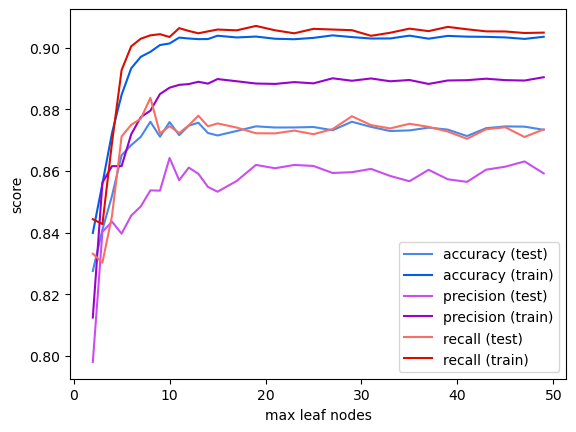

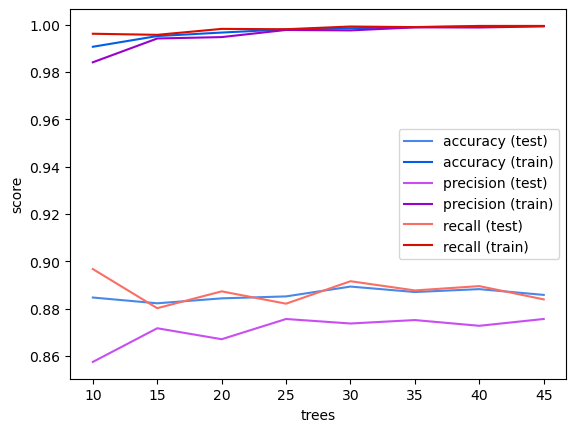

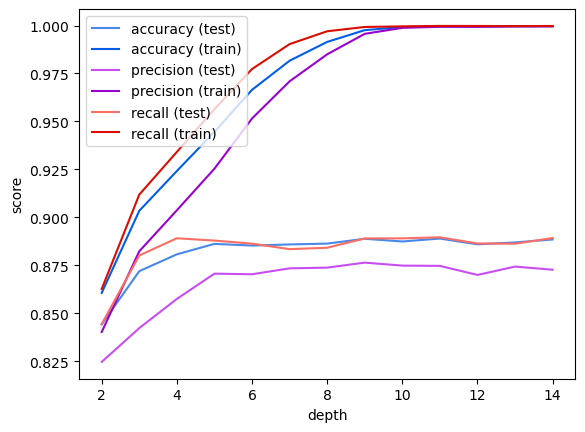

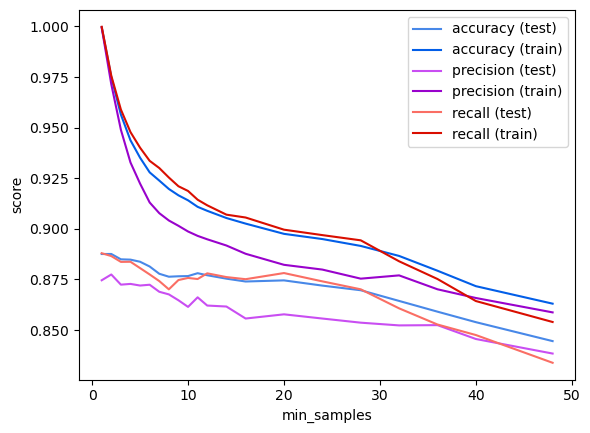

## 02/03 Determining performance increase with J, H and K filters

In [30]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'
train_file = 'training_data_2702_j.pk'
train_file = 'training_data_0203_jhk.pk'

# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

training_data = training_data[training_data['2mass_acc']==True]

In [53]:
# gather performance stats for random forest model
n_estimators_=30
max_depth_=[10,8,5,5,5]
max_leaf_nodes_=[15,15,12,12,12]
min_samples_leaf_=[10,10,15,15,15]
features_=['i','g','g-i','j','h','k']

recall = {}
accuracy = {}
for a in [2,3,4,5,6]:
    print(features_[:a])
    recall[a-2] = []
    accuracy[a-2] = []
    for i in range(200):
        _, test_pred, test_true, _, _ = ranfor(training_data,n_estimators=n_estimators_,
                                                                     max_depth=max_depth_[a-2], max_leaf_nodes=max_leaf_nodes_[a-2],
                                                                     min_samples_leaf=min_samples_leaf_[a-2], features=features_[:a],
                                                                     stats=True)
    
        tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
        recall[a-2].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        accuracy[a-2].append( (tp+tn)/(tn+fp+fn+tp) )# fraction of correctly identified objects
        
        

['i', 'g']
['i', 'g', 'i-g']
['i', 'g', 'i-g', 'j']
['i', 'g', 'i-g', 'j', 'h']
['i', 'g', 'i-g', 'j', 'h', 'k']


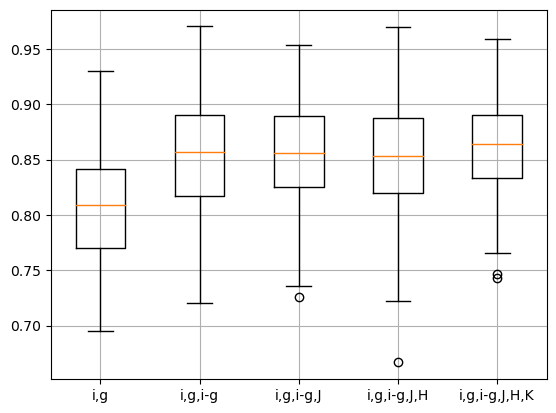

In [56]:
# using all training data except entries with inaccurate J values are filtered for the model using J
plt.boxplot([recall[i] for i in recall],labels=['i,g','i,g,g-i', 'i,g,g-i,J', 'i,g,g-i,J,H', 'i,g,g-i,J,H,K'])
plt.grid()
plt.show()

## 27/02 Determining if J filter increases prediction quality

In [22]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'
train_file = 'training_data_2702_j.pk'

# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

training_data = training_data[training_data['j_acc']==True]

In [37]:
# gather performance stats for random forest model
n_estimators_=30
max_depth_=[10,8,5]
max_leaf_nodes_=[15,15,12]
min_samples_leaf_=[10,10,15]
features_=['i','g','g-i','j']

recall = {}
accuracy = {}
for a in [2,3,4]:
    print(features_[:a])
    recall[a-2] = []
    accuracy[a-2] = []
    for i in range(10):
        _, test_pred, test_true, _, _ = ranfor(training_data,n_estimators=n_estimators_,
                                                                     max_depth=max_depth_[a-2], max_leaf_nodes=max_leaf_nodes_[a-2],
                                                                     min_samples_leaf=min_samples_leaf_[a-2], features=features_[:a],
                                                                     stats=True)
    
        tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
        recall[a-2].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        accuracy[a-2].append( (tp+tn)/(tn+fp+fn+tp) )# fraction of correctly identified objects

['i', 'g']
['i', 'g', 'i-g']
['i', 'g', 'i-g', 'j']


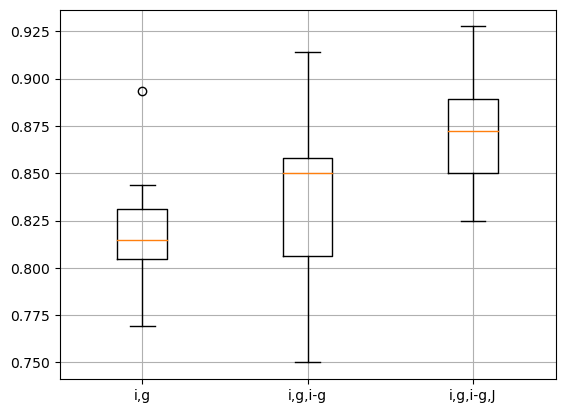

In [38]:
# using all training data except entries with inaccurate J values are filtered for the model using J
plt.boxplot([recall[0],recall[1],recall[2]],labels=['i,g','i,g,g-i', 'i,g,g-i,J'])
plt.grid()
plt.show()

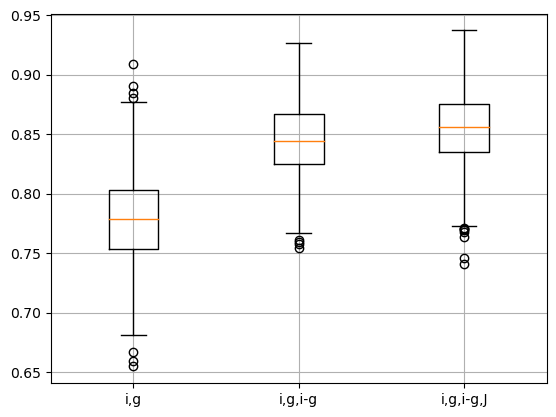

In [20]:
# using all training data
plt.boxplot([recall[0],recall[1],recall[2]],labels=['i,g','i,g,g-i', 'i,g,g-i,J'])
plt.grid()
plt.show()

### 27/02 Hyperparameter tuning on new dataset

In [105]:
# first on the reduced training set of only objects with an accurate J values

In [110]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'
train_file = 'training_data_2702_j.pk'

# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

training_data = training_data[training_data['j_acc']==True]

In [139]:
trees_range = range(5,50,2)
depth_range = range(2,15)
leaf_range = list(range(2,15))+list(range(15,50,2))
min_samples_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 20, 24, 28, 32, 36, 40, 48]

n_estimators_=30
max_depth_=8
max_leaf_nodes_=15
min_samples_leaf_=15
features_=['i','g','g-i','j']

In [140]:
rfstats_leaf = rf_vary_max_leaf_nodes(leaf_range, 1500,n_estimators=n_estimators_,max_depth=max_depth_,min_samples_leaf=min_samples_leaf_, features=features_)

calculating max leaf nodes 2...
calculating max leaf nodes 3...
calculating max leaf nodes 4...
calculating max leaf nodes 5...
calculating max leaf nodes 6...
calculating max leaf nodes 7...
calculating max leaf nodes 8...
calculating max leaf nodes 9...
calculating max leaf nodes 10...
calculating max leaf nodes 11...
calculating max leaf nodes 12...
calculating max leaf nodes 13...
calculating max leaf nodes 14...
calculating max leaf nodes 15...
calculating max leaf nodes 17...
calculating max leaf nodes 19...
calculating max leaf nodes 21...
calculating max leaf nodes 23...
calculating max leaf nodes 25...
calculating max leaf nodes 27...
calculating max leaf nodes 29...
calculating max leaf nodes 31...
calculating max leaf nodes 33...
calculating max leaf nodes 35...
calculating max leaf nodes 37...
calculating max leaf nodes 39...
calculating max leaf nodes 41...
calculating max leaf nodes 43...
calculating max leaf nodes 45...
calculating max leaf nodes 47...
calculating max le

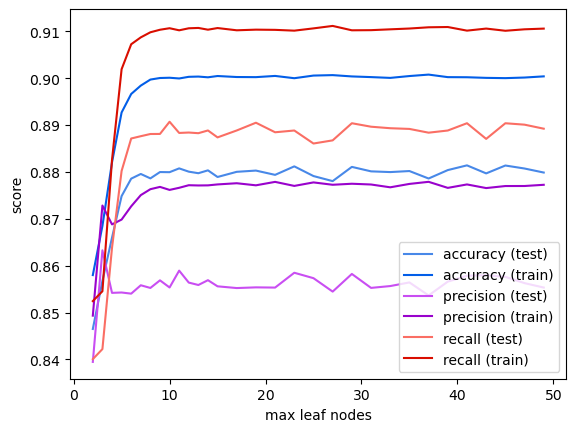

In [141]:
plot_stats(rfstats_leaf,'max leaf nodes')

In [136]:
rfstats_trees = rf_vary_trees(trees_range,500,features=features_)
rfstats_depth = rf_vary_max_depth(depth_range,500,features=features_)
rfstats_min_samples = rf_vary_min_samples_leaf(min_samples_range,500,features=features_)

calculating for 5 trees...
calculating for 7 trees...
calculating for 9 trees...
calculating for 11 trees...
calculating for 13 trees...
calculating for 15 trees...
calculating for 17 trees...
calculating for 19 trees...
calculating for 21 trees...
calculating for 23 trees...
calculating for 25 trees...
calculating for 27 trees...
calculating for 29 trees...
calculating for 31 trees...
calculating for 33 trees...
calculating for 35 trees...
calculating for 37 trees...
calculating for 39 trees...
calculating for 41 trees...
calculating for 43 trees...
calculating for 45 trees...
calculating for 47 trees...
calculating for 49 trees...
calculating max depth 2...
calculating max depth 3...
calculating max depth 4...
calculating max depth 5...
calculating max depth 6...
calculating max depth 7...
calculating max depth 8...
calculating max depth 9...
calculating max depth 10...
calculating max depth 11...
calculating max depth 12...
calculating max depth 13...
calculating max depth 14...
cal

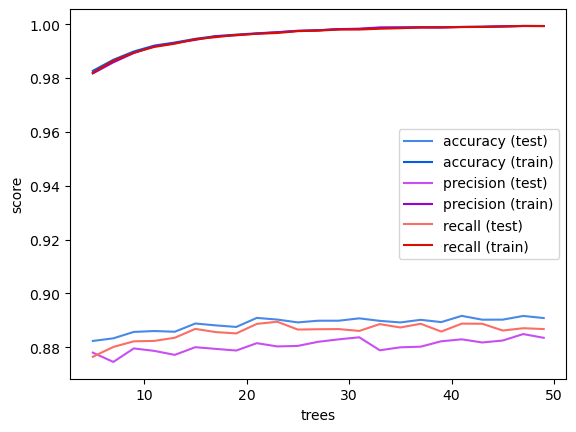

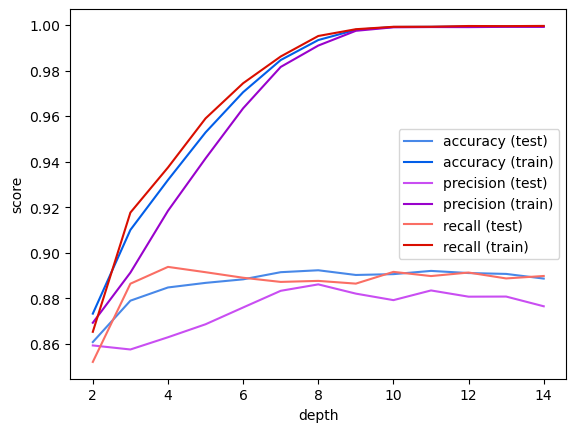

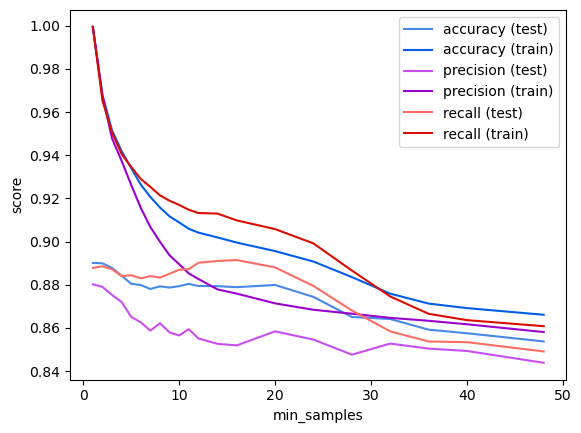

In [137]:
plot_stats(rfstats_trees,'trees')
plot_stats(rfstats_depth,'depth')
plot_stats(rfstats_min_samples,'min_samples')

### 17/02/2023 Hyperparameter tuning

In [29]:
list(range(10))+list(range(20,30))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

In [33]:
trees_range = range(10,60,4)
depth_range = range(2,25)
leaf_range = list(range(2,25))
min_samples_range = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 32, 36, 48]

In [34]:
rfstats_leaf = rf_vary_max_leaf_nodes(leaf_range, 100, max_depth=10, min_samples_leaf=10)

calculating max leaf nodes 2...
calculating max leaf nodes 3...
calculating max leaf nodes 4...
calculating max leaf nodes 5...
calculating max leaf nodes 6...
calculating max leaf nodes 7...
calculating max leaf nodes 8...
calculating max leaf nodes 9...
calculating max leaf nodes 10...
calculating max leaf nodes 11...
calculating max leaf nodes 12...
calculating max leaf nodes 13...
calculating max leaf nodes 14...


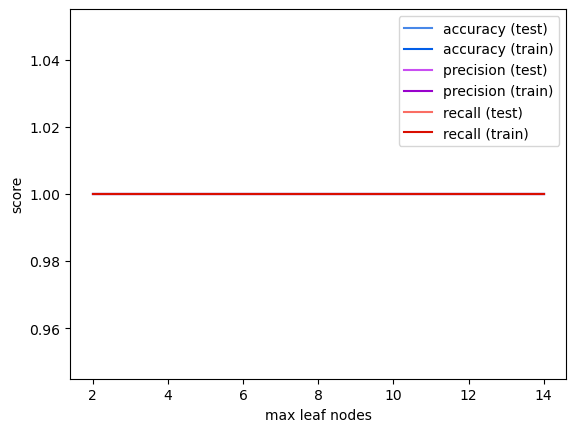

In [35]:
plot_stats(rfstats_leaf,'max leaf nodes')

In [108]:
rfstats_trees = rf_vary_trees(trees_range,200, max_depth=9, max_leaf_nodes=10,min_samples_leaf=10)
rfstats_depth = rf_vary_max_depth(depth_range, 200, max_leaf_nodes=10,min_samples_leaf=10)
rfstats_min_samples = rf_vary_min_samples_leaf(min_samples_range,200, max_depth=9, max_leaf_nodes=10)

calculating for 10 trees...
calculating for 14 trees...
calculating for 18 trees...
calculating for 22 trees...
calculating for 26 trees...
calculating for 30 trees...
calculating for 34 trees...
calculating for 38 trees...
calculating for 42 trees...
calculating for 46 trees...
calculating for 50 trees...
calculating for 54 trees...
calculating for 58 trees...
calculating max depth 2...
calculating max depth 3...
calculating max depth 4...
calculating max depth 5...
calculating max depth 6...
calculating max depth 7...
calculating max depth 8...
calculating max depth 9...
calculating max depth 10...
calculating max depth 11...
calculating max depth 12...
calculating max depth 13...
calculating max depth 14...
calculating max depth 15...
calculating max depth 16...
calculating max depth 17...
calculating max depth 18...
calculating max depth 19...
calculating max depth 20...
calculating max depth 21...
calculating max depth 22...
calculating max depth 23...
calculating max depth 24...


ValueError: At least one label specified must be in y_true

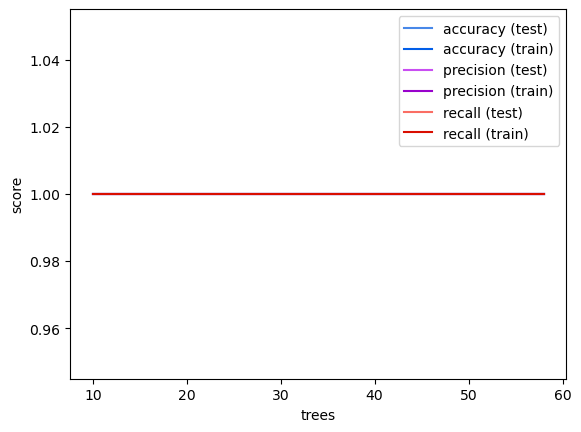

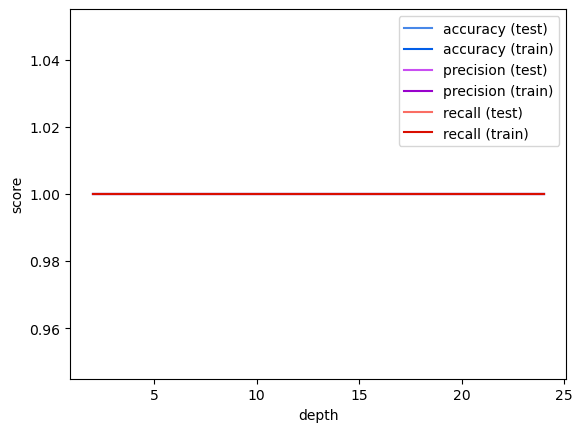

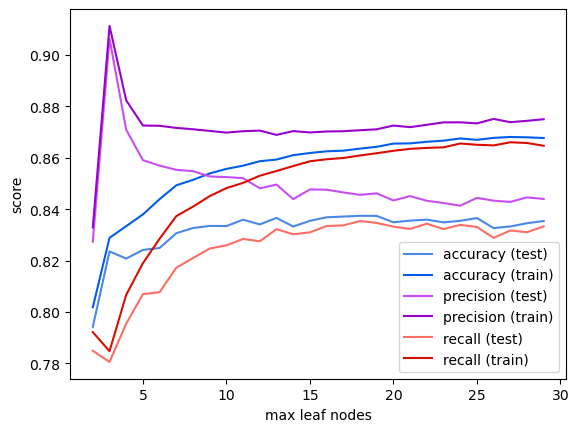

NameError: name 'rfstats_min_samples' is not defined

In [110]:
plot_stats(rfstats_trees,'trees')
plot_stats(rfstats_depth,'depth')
plot_stats(rfstats_min_samples,'min_samples')

### 16/02/2023

In [25]:
#load 
with open('./pickle/temp/rfstats_trees3.pk','rb') as f:
    rfstats_trees = pickle.load(f)
with open('./pickle/temp/rfstats_depth3.pk','rb') as f:
    rfstats_depth = pickle.load(f)
with open('./pickle/temp/rfstats_leaf3.pk','rb') as f:
    rfstats_leaf = pickle.load(f)
with open('./pickle/temp/rfstats_min_samples3.pk','rb') as f:
    rfstats_min_samples = pickle.load(f)

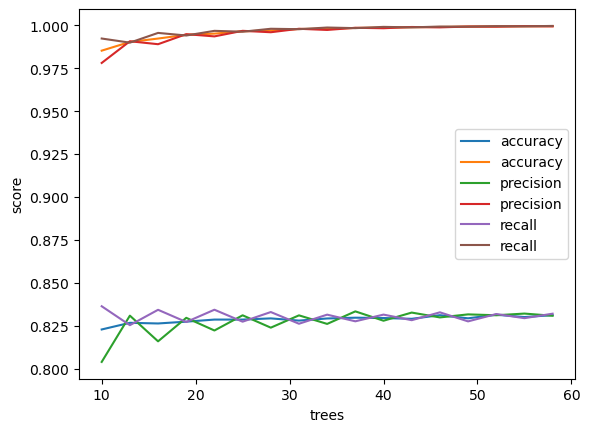

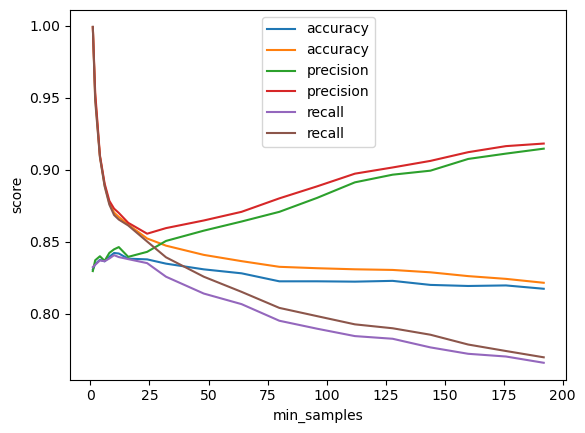

In [30]:
plot_stats(rfstats_trees,'trees')
plot_stats(rfstats_min_samples,'min_samples')

In [43]:
# min samples calc

In [45]:

min_samples_range = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 32, 36, 48, 64, 80]
rfstats_min_samples = rf_vary_min_samples_leaf(min_samples_range, 400)

calculating min samples 1...
calculating min samples 2...
calculating min samples 3...
calculating min samples 4...
calculating min samples 5...
calculating min samples 6...
calculating min samples 8...
calculating min samples 10...
calculating min samples 12...
calculating min samples 14...
calculating min samples 16...
calculating min samples 20...
calculating min samples 24...
calculating min samples 32...
calculating min samples 36...
calculating min samples 48...
calculating min samples 64...
calculating min samples 80...


In [31]:
# min samples plot

In [32]:
trees_range = range(10,60,3)
depth_range = range(2,25)
leaf_range = range(2,165,4)
min_samples_range = [1, 2, 4, 6, 8, 10, 12, 16, 24, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192]

In [47]:
rfstats_min_samples_test = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_min_samples_test:
    rfstats_min_samples_test[k] = [rfstats_min_samples[n][k][0] for n in rfstats_min_samples]
rfstats_min_samples_train = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_min_samples_train:
    rfstats_min_samples_train[k] = [rfstats_min_samples[n][k][1] for n in rfstats_min_samples]

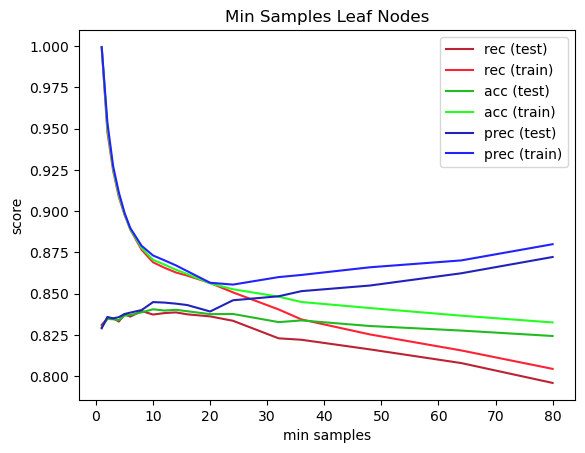

In [48]:
plt.plot(min_samples_range,rfstats_min_samples_test['rec'],c='#B23',label='rec (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['rec'],c='#F23',label='rec (train)')
plt.plot(min_samples_range,rfstats_min_samples_test['acc'],c='#2B2',label='acc (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['acc'],c='#2F2',label='acc (train)')
plt.plot(min_samples_range,rfstats_min_samples_test['prec'],c='#22B',label='prec (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['prec'],c='#22F',label='prec (train)')
plt.xlabel('min samples')
plt.ylabel('score')
plt.title('Min Samples Leaf Nodes')
plt.legend()
#plt.ylim([0.75,1])
plt.show()

### 15/02/2023

In [20]:
# select most recent training data
train_file = 'training_data_0802.pk'

In [21]:
# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)
#training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))
training_data_nostar = training_data[training_data['class'] != 'star']

In [22]:
training_data_nostar['g-i'] = training_data_nostar['i']-training_data_nostar['g']

C:\Users\jwarn\AppData\Local\Temp\ipykernel_20648\1434339991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_nostar['i-g'] = training_data_nostar['i']-training_data_nostar['g']


In [23]:
len(range(1,200,5))

40

In [24]:
trees_range = range(10,60,3)
depth_range = range(2,25)
leaf_range = range(2,165,4)
min_samples_range = [1, 2, 4, 6, 8, 10, 12, 16, 24, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192]

In [177]:
rfstats_min_samples = rf_vary_min_samples_leaf(min_samples_range, 1000)
rfstats_trees = rf_vary_trees(trees_range, 1000)
rfstats_depth = rf_vary_max_depth(depth_range, 1000)
rfstats_leaf = rf_vary_max_leaf_nodes(leaf_range, 1000)

calculating min samples 1...
calculating min samples 2...
calculating min samples 4...
calculating min samples 6...
calculating min samples 8...
calculating min samples 10...
calculating min samples 12...
calculating min samples 16...
calculating min samples 24...
calculating min samples 32...
calculating min samples 48...
calculating min samples 64...
calculating min samples 80...
calculating min samples 96...
calculating min samples 112...
calculating min samples 128...
calculating min samples 144...
calculating min samples 160...
calculating min samples 176...
calculating min samples 192...
calculating for 10 trees...
calculating for 13 trees...
calculating for 16 trees...
calculating for 19 trees...
calculating for 22 trees...
calculating for 25 trees...
calculating for 28 trees...
calculating for 31 trees...
calculating for 34 trees...
calculating for 37 trees...
calculating for 40 trees...
calculating for 43 trees...
calculating for 46 trees...
calculating for 49 trees...
calcula

**.pk - 14/02*  
**2.pk - 15/02 (incl g-i as a feature now)*  
**3.pk - 15/02 "" "" (more iterations)*

In [178]:
#save
with open('./pickle/temp/rfstats_trees3.pk','wb') as f:
    pickle.dump(rfstats_trees,f)
with open('./pickle/temp/rfstats_depth3.pk','wb') as f:
    pickle.dump(rfstats_depth,f)
with open('./pickle/temp/rfstats_leaf3.pk','wb') as f:
    pickle.dump(rfstats_leaf,f)
with open('./pickle/temp/rfstats_min_samples3.pk','wb') as f:
    pickle.dump(rfstats_min_samples,f)

In [179]:
rfstats_min_samples_test = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_min_samples_test:
    rfstats_min_samples_test[k] = [rfstats_min_samples[n][k][0] for n in rfstats_min_samples]
rfstats_min_samples_train = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_min_samples_train:
    rfstats_min_samples_train[k] = [rfstats_min_samples[n][k][1] for n in rfstats_min_samples]

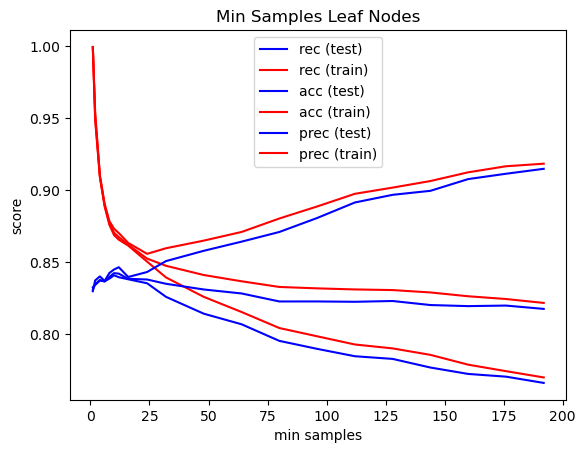

In [185]:
plt.plot(min_samples_range,rfstats_min_samples_test['rec'],c='b',label='rec (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['rec'],c='r',label='rec (train)')
plt.plot(min_samples_range,rfstats_min_samples_test['acc'],c='b',label='acc (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['acc'],c='r',label='acc (train)')
plt.plot(min_samples_range,rfstats_min_samples_test['prec'],c='b',label='prec (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['prec'],c='r',label='prec (train)')
plt.xlabel('min samples')
plt.ylabel('score')
plt.title('Min Samples Leaf Nodes')
plt.legend()
#plt.ylim([0.75,1])
plt.show()

In [182]:
rfstats_leaf_test = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_leaf_test:
    rfstats_leaf_test[k] = [rfstats_leaf[n][k][0] for n in rfstats_leaf]
rfstats_leaf_train = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_leaf_train:
    rfstats_leaf_train[k] = [rfstats_leaf[n][k][1] for n in rfstats_leaf]

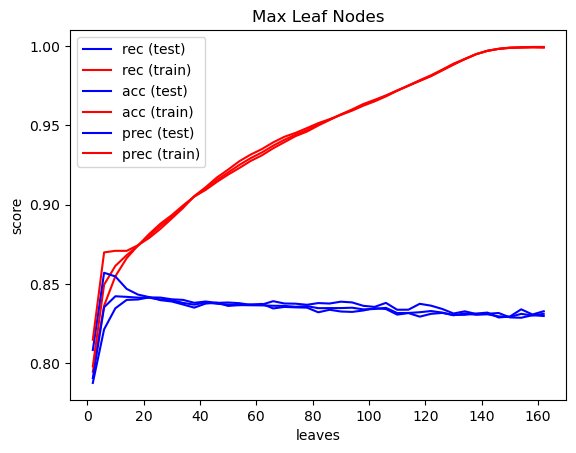

In [183]:
plt.plot(leaf_range,rfstats_leaf_test['rec'],c='b',label='rec (test)')
plt.plot(leaf_range,rfstats_leaf_train['rec'],c='r',label='rec (train)')
plt.plot(leaf_range,rfstats_leaf_test['acc'],c='b',label='acc (test)')
plt.plot(leaf_range,rfstats_leaf_train['acc'],c='r',label='acc (train)')
plt.plot(leaf_range,rfstats_leaf_test['prec'],c='b',label='prec (test)')
plt.plot(leaf_range,rfstats_leaf_train['prec'],c='r',label='prec (train)')
plt.xlabel('leaves')
plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.legend()
#plt.ylim([0.75,1])
plt.show()

### 13/02/2023 Optimising hyperparameters of Random Forest

In [11]:
# select most recent training data
train_file = 'training_data_0802.pk'

In [12]:
# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)
#training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))
training_data_nostar = training_data[training_data['class'] != 'star']

In [15]:
training_data_nostar['g-i'] = training_data_nostar['i']-training_data_nostar['g']

C:\Users\jwarn\AppData\Local\Temp\ipykernel_12140\1434339991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_nostar['i-g'] = training_data_nostar['i']-training_data_nostar['g']


In [16]:
training_data_nostar

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106,-1.500999
2003,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156,-1.016001
2004,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163,-0.997000
2005,PA-N147-3,gc,19.910000,20.820999,0.004,0.004,8.542029,49.044243,402,101369,91,36,-0.910999


In [167]:
# gather performance stats for random forest model

rf_classifier, test_pred, test_true, train_pred, train_true = ranfor(training_data_nostar,n_estimators=50,max_depth=8, max_leaf_nodes=25,min_samples_leaf=100, stats=True)

tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'Test Scores:\nrecall:{recall}\nprecision:{precision}\naccuracy:{accuracy}\n')

tn, fp, fn, tp = confusion_matrix(train_true,train_pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'Train Scores:\nrecall:{recall}\nprecision:{precision}\naccuracy:{accuracy}\n')

Test Scores:
recall:0.8692307692307693
precision:0.773972602739726
accuracy:0.7789855072463768

Train Scores:
recall:0.8851224105461394
precision:0.8173913043478261
accuracy:0.8047016274864376



In [136]:
max_depth_range = range(2,9,2)
iterations = range(5)
stats = {}

for n in max_depth_range:
    stats[n] = {'acc':[],'prec':[],'rec':[]}
    for i in iterations:
        _, test_pred, test_true, train_pred, train_true = ranfor(training_data_nostar,n_estimators=50,max_depth=n, max_leaf_nodes=3,  stats=True)
        tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()
        stats[n]['rec'].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        stats[n]['acc'].append( (tp+tn)/(tn+fp+fn+tp) ) # fraction of correctly identified objects
        stats[n]['prec'].append( tp/(tp+fp) ) # fraction of correctly identified GCs, out of what were thought to be GCs
    for k in stats[n]:
        stats[n][k] = sum(stats[n][k])/len(iterations)

NameError: name 'true' is not defined

In [79]:
trees_range = range(10,150,5)
depth_range = range(2,41)
leaf_range = range(10,200,5)

In [74]:
rfstats_trees = rf_vary_trees(range(10,150,5), 300)
rfstats_depth = rf_vary_max_depth(range(2,41), 300)
rfstats_leaf = rf_vary_max_leaf_nodes(range(10,200,5), 300)

calculating for 10 trees...
calculating for 15 trees...
calculating for 20 trees...
calculating for 25 trees...
calculating for 30 trees...
calculating for 35 trees...
calculating for 40 trees...
calculating for 45 trees...
calculating for 50 trees...
calculating for 55 trees...
calculating for 60 trees...
calculating for 65 trees...
calculating for 70 trees...
calculating for 75 trees...
calculating for 80 trees...
calculating for 85 trees...
calculating for 90 trees...
calculating for 95 trees...
calculating for 100 trees...
calculating for 105 trees...
calculating for 110 trees...
calculating for 115 trees...
calculating for 120 trees...
calculating for 125 trees...
calculating for 130 trees...
calculating for 135 trees...
calculating for 140 trees...
calculating for 145 trees...
calculating max depth 2...
calculating max depth 3...
calculating max depth 4...
calculating max depth 5...
calculating max depth 6...
calculating max depth 7...
calculating max depth 8...
calculating max d

**.pk - 14/02*  
**2.pk - 15/02 (incl g-i as a feature now)*

In [75]:
with open('./pickle/temp/rfstats_trees2.pk','wb') as f:
    pickle.dump(rfstats_trees,f)
with open('./pickle/temp/rfstats_depth2.pk','wb') as f:
    pickle.dump(rfstats_depth,f)
with open('./pickle/temp/rfstats_leaf2.pk','wb') as f:
    pickle.dump(rfstats_leaf,f)

In [112]:
rfstats_leaf_test = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_leaf_test:
    rfstats_leaf_test[k] = [rfstats_leaf[n][k][0] for n in rfstats_leaf]
rfstats_leaf_train = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_leaf_train:
    rfstats_leaf_train[k] = [rfstats_leaf[n][k][1] for n in rfstats_leaf]

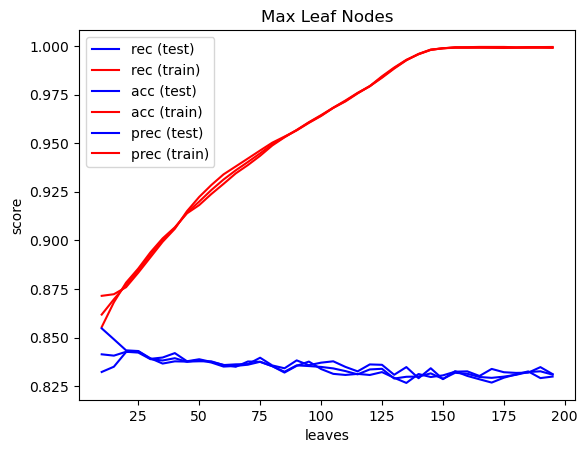

In [113]:
plt.plot(leaf_range,rfstats_leaf_test['rec'],c='b',label='rec (test)')
plt.plot(leaf_range,rfstats_leaf_train['rec'],c='r',label='rec (train)')
plt.plot(leaf_range,rfstats_leaf_test['acc'],c='b',label='acc (test)')
plt.plot(leaf_range,rfstats_leaf_train['acc'],c='r',label='acc (train)')
plt.plot(leaf_range,rfstats_leaf_test['prec'],c='b',label='prec (test)')
plt.plot(leaf_range,rfstats_leaf_train['prec'],c='r',label='prec (train)')
plt.xlabel('leaves')
plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.legend()
#plt.ylim([0.75,1])
plt.show()

In [95]:
def make_predictions():
    field = 222
    #RF
    predictions_rf = rf_pred(field,training_data_nostar,crowding=300)
    #with open(f'pickle/temp/predictionsf{field}.pk','wb') as f:
        #pickle.dump(predictions,f)
    len(predictions_rf[predictions_rf['pred'] == 'gc'])
    with open(f'pickle/temp/predictionsf222_0802test.pk','wb') as f:
        pickle.dump(predictions,f)

### 08/02/2023 Predictions and Training

Automate training

In [14]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [17]:
training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))
training_data_nostar = training_data[training_data['class'] != 'star']

C:\Users\jwarn\AppData\Local\Temp\ipykernel_19844\3009024223.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/training_data/training_data_0802.pk'>
  training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))


In [178]:
#RF

rf_classifier, pred, true = ranfor(training_data_nostar,n_estimators=50,max_depth=5, max_leaf_nodes=3,  stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'recall:{recall}\nprecision:{precision}\naccuracy:{accuracy}')

recall:0.848
precision:0.7851851851851852
accuracy:0.8346153846153846


In [14]:
field = 222
#RF
predictions_rf = rf_pred(field,training_data_nostar,crowding=300)
#with open(f'pickle/temp/predictionsf{field}.pk','wb') as f:
    #pickle.dump(predictions,f)
len(predictions_rf[predictions_rf['pred'] == 'gc'])

NameError: name 'training_data_nostar' is not defined

In [198]:
#SVC

svc_classifier, pred, true = svc_class(training_data_nostar, stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn)
recall

0.6946107784431138

#MLP

mlp_classifier, pred, true = mlp_class(training_data_nostar,hidden_layer_sizes=(20,),activation='logistic',alpha=0.0001, stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'recall:{recall}\nprecision:{precision}\naccuracy:{accuracy}')

In [223]:
with open(f'pickle/temp/predictionsf222_0802test.pk','wb') as f:
    pickle.dump(predictions,f)

#### 05/02/2023

In [140]:
x = range(1,300,1)

In [148]:
y = [ len(training_data[training_data['nearby'] <= i]) for i in x ]

In [146]:
y = [ len(training_data_nostar[training_data_nostar['nearby'] <= i]) for i in x ]

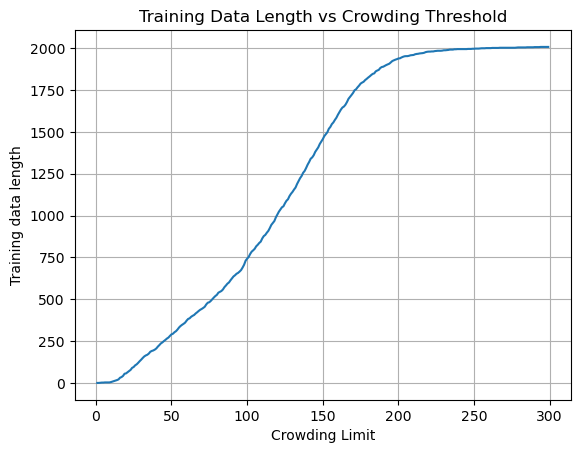

In [149]:
plt.plot(x,y)
plt.xlabel('Crowding Limit')
plt.ylabel('Training data length')
plt.title('Training Data Length vs Crowding Threshold')
plt.grid()

In [14]:
train_file = 'training_data_0502.pk'

In [11]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [15]:
training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))

In [16]:
training_data_nostar = training_data[training_data['class'] != 'star']

In [17]:
training_data_nostar

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby
0,HM33-A,gc,21.163000,22.052999,0.009,0.009,23.924183,28.820591,5,39696,2647,49
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2223,FJJ-IV,gc,18.417999,19.346001,0.002,0.002,9.801158,48.380100,398,168491,369,167
2224,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106
2225,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156
2226,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163


In [105]:
stats = ranfor(training_data_nostar,train_size=0.8, n_estimators=5, stats=True, max_depth=8, max_leaf_nodes=5)
stats[2]

0.7737704918032787

In [107]:
tn, fp, fn, tp = confusion_matrix(stats[1],stats[0],labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn)
recall

0.75

In [389]:
rf_model  = ranfor(training_data_star, n_estimators=100)

#### Testing filtering the catalogues for prediction

In [205]:
cat = load_cat(26)[26].to_pandas()

In [213]:
cat_d = cat[cat['dg']+cat['di'] < 0.05]

In [231]:
cat_candidate = cat_d[~((cat_d['ig'] == -1) | (cat_d['ii'] == -1) | (cat_d['ig'] == -9) | (cat_d['ii'] == -9))] # drop stars & saturated points

#### Testing making predictions

In [83]:
test_ = predictions[~((predictions['ig'] == -1) | (predictions['ii'] == -1) )]

In [85]:
len(test_[test_['pred']=='gc'])

2487

In [236]:
field = 208
#RF
predictions = rf_pred(field,training_data_nostar,crowding=300)
with open(f'pickle/temp/predictionsf{field}1102.pk','wb') as f:
    pickle.dump(predictions,f)
len(predictions[predictions['pred'] == 'gc'])

Loading cat201_235.pk ...


C:\Users\jwarn\AppData\Local\Temp\ipykernel_19844\2525829327.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/cat201_235.pk'>
  catalogue = pickle.load(open(f'./pickle/{to_load}','rb'))


1488

In [222]:
gcs = predictions[predictions['pred']=='gc']

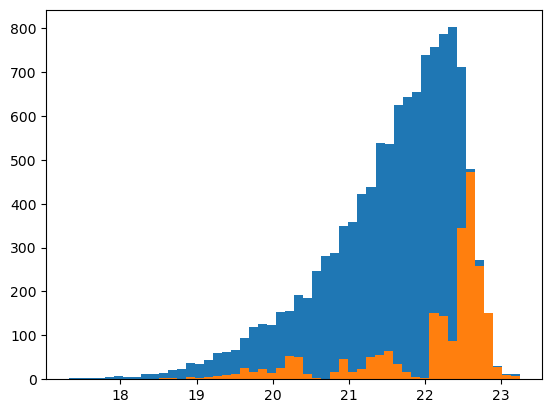

In [232]:
gcs = predictions[predictions['pred']=='gc']
gcs_44 = gcs#[(gcs['g']+gcs['i']<44) & (gcs['g']+gcs['i'] > 30)]

plt.hist(predictions['i'],bins=50)
plt.hist(gcs['i'],bins=50)

plt.show()


### Test

In [29]:
training_data_MAIN = pickle.load(open(f'./pickle/training_data/{train_files[0]}','rb'))

training_data = training_data_MAIN[300]

test_data = training_data[training_data['di']+training_data['dg'] < 0.1][training_data['class'] != 'star']

test_gcs = test_data[test_data['class'] == 'gc']

test_data

C:\Users\jwarn\AppData\Local\Temp\ipykernel_16988\1346209107.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = training_data[training_data['di']+training_data['dg'] < 0.1][training_data['class'] != 'star']


,obj_id,class,i,g,di,dg,ra,dec,field,pdidx
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860
...,...,...,...,...,...,...,...,...,...,...
2288,FJJ-VIII,gc,17.910999,18.806000,0.001,0.001,9.848991,48.312565,398,168456
2289,FJJ-IV,gc,18.417999,19.346001,0.002,0.002,9.801158,48.380100,398,168491
2290,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376
2291,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423


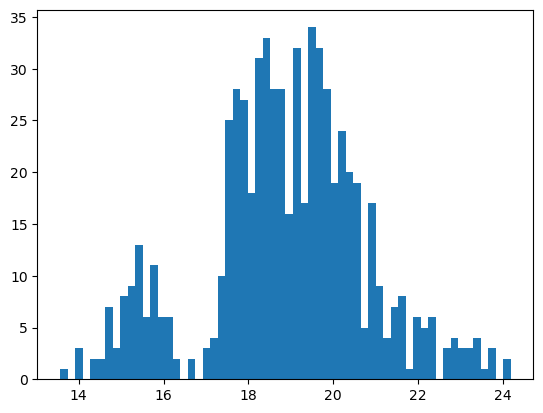

In [32]:
plt.hist(test_gcs['g'],bins=60)
plt.show()

In [ ]:
results = []
for 

In [ ]:
results = []
for file_name in train_files:
    training_data = pickle.load(open(f'./pickle/training_data/{file_name}','rb'))
    test_data = pickle.load(open(f'./pickle/{cat_files[3]}','rb'))[184] # field 184
    results.append(ranfor(training_data[250]).predict(test_data))

In [43]:
CAT = load_cat(188)

In [68]:
cat = CAT[188]

In [79]:
cat_smalldelta = cat[cat['dg']+cat['di'] < 0.1]

In [80]:
X = cat_smalldelta[['i','g']]

In [81]:
X = X.to_pandas()

In [82]:
X

,i,g
0,13.206000,13.678000
1,13.272000,13.694000
2,13.528000,13.924000
3,13.246000,13.950000
4,13.625000,13.929000
...,...,...
53345,21.943001,24.875999
53346,21.957001,24.913000
53347,21.662001,24.964001
53348,21.547001,24.981001


In [125]:
f = ['training_data_d006.pk','training_data_d005.pk','training_data_d004.pk','training_data_d003.pk']

In [126]:
training_data = pickle.load(open(f'./pickle/training_data/{f[1]}','rb'))

In [93]:
test_results = ranfor(test_, n_estimators=70, stats=True)

In [95]:
predictions188 = ranfor(test_, n_estimators=60).predict(X)

In [94]:
test_results[2] # yay!

0.8382352941176471

In [105]:
cat_smalldelta['pred'] = predictions188

In [100]:
cat395_pred = cat[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [101]:
cat395_pred['pred'] = res

In [103]:
with open('./pickle/ml_results/field395_predictions.pk','wb') as f:
    pickle.dump(cat395_pred,f)

In [84]:
test_ = pickle.load(open('./pickle/ml_results/field273_predictions.pk','rb'))

In [128]:
cat188_pred = cat[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [129]:
cat188_pred['pred'] = res

In [130]:
with open('./pickle/ml_results/field188_predictions.pk','wb') as f:
    pickle.dump(cat188_pred,f)

In [115]:
cat24_pred = cat24[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [116]:
cat24_pred['pred'] = res

In [117]:
with open('./pickle/ml_results/field24_predictions.pk','wb') as f:
    pickle.dump(cat24_pred,f)

In [53]:
# iterate to find best values
crowding_test_values = [300,275,250,225,200,175,150,125,100,75,50]
trees = [10,25,50,60,80,120]
accuracies = {}
iterations = 3

for m in object_match_files:
    obj_mat = pickle.load(open(f'./pickle/matches/{m}','rb'))
    accuracies[m[-4:-3]] = []
    for c in trees:#crowding_test_values:
        acc_t = 0 # total accuracy sum
        for i in range(iterations):
            t1 = time()
            #training_data, _ = generate_training_data(obj_mat, crowding=250) #stupid!
            _, __, acc = ranfor(training_data, n_estimators=c)
            acc_t += acc
            t2 = time()
            print(t2-t1)
        acc_t /= iterations
        accuracies[m[-4:-3]].append(acc_t)
        print(f'crowding: {c}, accuracy: {acc_t}')
        

59.16055750846863
55.01980996131897
53.677734375
crowding: 300, accuracy: 0.6144170295113692
51.2863883972168
54.201602935791016
66.1094582080841
crowding: 275, accuracy: 0.6368604073522107
77.24949383735657
71.25472140312195
73.84445881843567
crowding: 250, accuracy: 0.60671834625323
67.04550671577454
55.90899848937988
55.41255736351013
crowding: 225, accuracy: 0.6017094017094017
52.776262044906616
52.33641076087952


KeyboardInterrupt: 

In [ ]:
with open('./pickle/ml_results/accuracies_d00654_300-50--25.pk','wb') as f:
    pickle.dump(accuracies,f)

In [ ]:
#d005
plt.plot(crowding_test_values, accuracies[4], 'g')
plt.plot(crowding_test_values, accuracies[5], 'b')
plt.plot(crowding_test_values, accuracies[6], 'r')

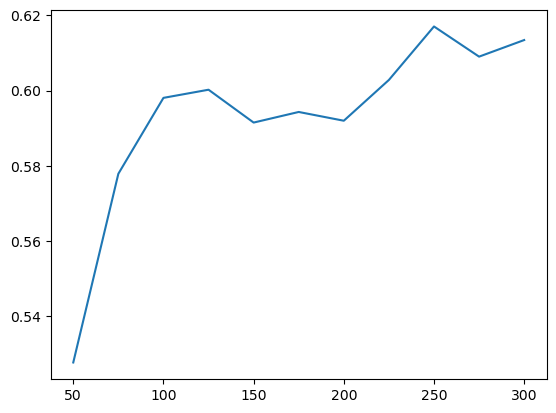

In [39]:
#d006
plt.plot(crowding_test_values, accuracies)